# Population Segmentation into Major Cities and Counties Using Kmeans Clustering


This project aims to find natural groupings in population data that reveal some feature-level similarities between different regions in the US. This is a useful itinary for any organisation or entity that works based on targeted audience. For instance, a political party would need data on the type of citizens and the number of men and women in the city, to begin his campaign. This analysis helps anyone in knowing their audience.


Using principal component analysis (PCA) I reduced the dimensionality of the original census data. Then, used k-means clustering to assign each US county to a particular cluster based on where a county lies in component space. How each cluster is arranged in component space can tell you which US counties are most similar and what demographic traits define that similarity; this information is most often used to inform targeted, marketing campaigns that want to appeal to a specific group of people. This cluster information is also useful for learning more about a population by revealing patterns between regions that you otherwise may not have noticed.

In [2]:
#Import the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Neccessary visualization Functions

###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,14))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax
    

def channel_results(reduced_data, outliers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
	Data is labeled by "Channel" and cues added for student-selected sample data
	'''

	# Check that the dataset is loadable
	try:
	    full_data = pd.read_csv(r"C:\Users\OMO_MUSHIN\Desktop\Wholesale customers data.csv")
	except:
	    print ("Dataset could not be loaded. Is the file missing?")
	    return False

	# Create the Channel DataFrame
	channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
	channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
	labeled = pd.concat([reduced_data, channel], axis = 1)
	
	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned Channel
	labels = ['Hotel/Restaurant/Cafe', 'Retailer']
	grouped = labeled.groupby('Channel')
	for i, channel in grouped:   
	    channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
	    
	# Plot transformed sample points   
	for i, sample in enumerate(pca_samples):
		ax.scatter(x = sample[0], y = sample[1], \
	           s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
		ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

	# Set plot title
	ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

# Loading the dataset


The dataset consists of 3220 rows of sample cities and counties and 37 columns. Some of these columns are in percentages(Walk, MeanCommute) are in whole figures(TotalPop, Men, etc)

In [4]:
data = pd.read_csv(r'C:\Users\OMO_MUSHIN\Desktop\data\acs2015_county_data.csv')
data.head()


CensusId    State   County  TotalPop    Men  Women  Hispanic  White  Black  \
0      1001  Alabama  Autauga     55221  26745  28476       2.6   75.8   18.5   
1      1003  Alabama  Baldwin    195121  95314  99807       4.5   83.1    9.5   
2      1005  Alabama  Barbour     26932  14497  12435       4.6   46.2   46.7   
3      1007  Alabama     Bibb     22604  12073  10531       2.2   74.5   21.4   
4      1009  Alabama   Blount     57710  28512  29198       8.6   87.9    1.5   

   Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0     0.4  ...   0.5          1.3         1.8         26.5     23986   
1     0.6  ...   1.0          1.4         3.9         26.4     85953   
2     0.2  ...   1.8          1.5         1.6         24.1      8597   
3     0.4  ...   0.6          1.5         0.7         28.8      8294   
4     0.3  ...   0.9          0.4         2.3         34.9     22189   

   PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  
0         73.6        20.9           5.5         0.0           7.6  
1         81.5        12.3           5.8         0.4           7.5  
2         71.8        20.8           7.3         0.1          17.6  
3         76.8        16.1           6.7         0.4           8.3  
4         82.0        13.5           4.2         0.4           7.7  

[5 rows x 37 columns]

# Exploratory Data Analysis

In [5]:
data.shape

(3220, 37)

In [6]:
data.columns.values

array(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional',
       'Service', 'Office', 'Construction', 'Production', 'Drive',
       'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'], dtype=object)

In [7]:
data.describe()

CensusId      TotalPop           Men         Women     Hispanic  \
count   3220.000000  3.220000e+03  3.220000e+03  3.220000e+03  3220.000000   
mean   31393.605280  9.940935e+04  4.889694e+04  5.051241e+04    11.011522   
std    16292.078954  3.193055e+05  1.566813e+05  1.626620e+05    19.241380   
min     1001.000000  8.500000e+01  4.200000e+01  4.300000e+01     0.000000   
25%    19032.500000  1.121800e+04  5.637250e+03  5.572000e+03     1.900000   
50%    30024.000000  2.603500e+04  1.293200e+04  1.305700e+04     3.900000   
75%    46105.500000  6.643050e+04  3.299275e+04  3.348750e+04     9.825000   
max    72153.000000  1.003839e+07  4.945351e+06  5.093037e+06    99.900000   

             White        Black       Native        Asian      Pacific  ...  \
count  3220.000000  3220.000000  3220.000000  3220.000000  3220.000000  ...   
mean     75.428789     8.665497     1.723509     1.229068     0.082733  ...   
std      22.932890    14.279122     7.253115     2.633079     0.734931  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%      64.100000     0.500000     0.100000     0.200000     0.000000  ...   
50%      84.100000     1.900000     0.300000     0.500000     0.000000  ...   
75%      93.200000     9.600000     0.600000     1.200000     0.000000  ...   
max      99.800000    85.900000    92.100000    41.600000    35.300000  ...   

              Walk  OtherTransp   WorkAtHome  MeanCommute      Employed  \
count  3220.000000  3220.000000  3220.000000  3220.000000  3.220000e+03   
mean      3.323509     1.612733     4.631770    23.278758  4.559352e+04   
std       3.756096     1.670988     3.178772     5.600466  1.496995e+05   
min       0.000000     0.000000     0.000000     4.900000  6.200000e+01   
25%       1.400000     0.900000     2.700000    19.500000  4.550750e+03   
50%       2.400000     1.300000     3.900000    23.000000  1.050800e+04   
75%       4.000000     1.900000     5.600000    26.800000  2.863275e+04   
max      71.200000    39.100000    37.200000    44.000000  4.635465e+06   

       PrivateWork   PublicWork  SelfEmployed   FamilyWork  Unemployment  
count  3220.000000  3220.000000   3220.000000  3220.000000   3220.000000  
mean     74.219348    17.560870      7.931801     0.288106      8.094441  
std       7.863188     6.510354      3.914974     0.455137      4.096114  
min      25.000000     5.800000      0.000000     0.000000      0.000000  
25%      70.500000    13.100000      5.400000     0.100000      5.500000  
50%      75.700000    16.200000      6.900000     0.200000      7.600000  
75%      79.700000    20.500000      9.400000     0.300000      9.900000  
max      88.300000    66.200000     36.600000     9.800000     36.500000  

[8 rows x 35 columns]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusId         3220 non-null   int64  
 1   State            3220 non-null   object 
 2   County           3220 non-null   object 
 3   TotalPop         3220 non-null   int64  
 4   Men              3220 non-null   int64  
 5   Women            3220 non-null   int64  
 6   Hispanic         3220 non-null   float64
 7   White            3220 non-null   float64
 8   Black            3220 non-null   float64
 9   Native           3220 non-null   float64
 10  Asian            3220 non-null   float64
 11  Pacific          3220 non-null   float64
 12  Citizen          3220 non-null   int64  
 13  Income           3219 non-null   float64
 14  IncomeErr        3219 non-null   float64
 15  IncomePerCap     3220 non-null   int64  
 16  IncomePerCapErr  3220 non-null   int64  
 17  Poverty       

# Cleaning the data of all null values

Every null values was filled with mean of the respective columns. This was done instead of removing the null values to reduce loss of data

In [9]:
na_columns = ['Income', 'IncomeErr', 'ChildPoverty']
for i in na_columns:
    data[i] = data[i].fillna(np.mean(data[i]))


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusId         3220 non-null   int64  
 1   State            3220 non-null   object 
 2   County           3220 non-null   object 
 3   TotalPop         3220 non-null   int64  
 4   Men              3220 non-null   int64  
 5   Women            3220 non-null   int64  
 6   Hispanic         3220 non-null   float64
 7   White            3220 non-null   float64
 8   Black            3220 non-null   float64
 9   Native           3220 non-null   float64
 10  Asian            3220 non-null   float64
 11  Pacific          3220 non-null   float64
 12  Citizen          3220 non-null   int64  
 13  Income           3220 non-null   float64
 14  IncomeErr        3220 non-null   float64
 15  IncomePerCap     3220 non-null   int64  
 16  IncomePerCapErr  3220 non-null   int64  
 17  Poverty       

# Selecting Random Samples for analysis

To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail.

In [11]:
np.random.seed(50)
indices = np.random.randint(0, data.shape[0], 10).tolist()

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print ("Chosen samples of population segment dataset:")
display(samples)

Chosen samples of population segment dataset:


CensusId           State              County  TotalPop     Men   Women  \
0     31117        Nebraska           McPherson       433     223     210   
1     29043        Missouri           Christian     80904   39288   41616   
2     37083  North Carolina             Halifax     53407   25620   27787   
3     40053        Oklahoma               Grant      4517    2228    2289   
4     38049    North Dakota             McHenry      5817    3046    2771   
5      5043        Arkansas                Drew     18740    9215    9525   
6     39151            Ohio               Stark    374979  181905  193074   
7     42067    Pennsylvania             Juniata     24829   12384   12445   
8      2050          Alaska  Bethel Census Area     17776    9351    8425   
9     72125     Puerto Rico          San Germán     34125   16590   17535   

   Hispanic  White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  \
0       0.9   97.5    0.0     0.0  ...  15.7          4.6        22.6   
1       2.8   93.7    0.6     0.4  ...   0.7          1.5         4.6   
2       2.6   39.2   51.9     3.2  ...   1.8          1.2         1.7   
3       4.1   89.9    0.4     0.5  ...   3.7          1.1         3.3   
4       2.4   95.3    0.2     0.6  ...   7.8          0.6         9.6   
5       2.9   66.9   28.8     0.1  ...   1.8          0.8         2.3   
6       1.8   87.2    7.1     0.1  ...   1.6          0.6         2.8   
7       2.9   95.2    0.8     0.1  ...   3.4          0.9         5.2   
8       1.8   11.3    0.8    80.6  ...  33.0         22.6         4.8   
9      99.6    0.3    0.1     0.0  ...   3.0          0.9         3.7   

   MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
0         32.0       222         69.4         5.9          23.9         0.9   
1         26.3     37578         81.4        12.2           6.3         0.1   
2         23.9     19726         76.7        17.6           5.6         0.1   
3         19.9      2098         64.7        17.5          17.7         0.1   
4         27.2      2840         66.8        13.6          19.4         0.2   
5         22.1      7361         69.9        22.5           7.5         0.1   
6         21.6    174941         84.4        10.2           5.3         0.1   
7         28.8     11152         81.6        11.0           7.2         0.2   
8          7.4      6232         53.2        44.8           2.0         0.0   
9         26.5      8803         67.1        22.7           9.8         0.4   

   Unemployment  
0           0.9  
1           6.4  
2          14.1  
3           3.6  
4           3.1  
5          14.3  
6           8.5  
7           5.7  
8          17.6  
9           6.8  

[10 rows x 37 columns]

In [12]:
# index data by 'State-County'

data.index = data['State'] + '-' + data['County']
data.head()

drop=["CensusId" , "State" , "County"]
new_data = data.drop(columns=drop)
new_data.head()

TotalPop    Men  Women  Hispanic  White  Black  Native  \
Alabama-Autauga     55221  26745  28476       2.6   75.8   18.5     0.4   
Alabama-Baldwin    195121  95314  99807       4.5   83.1    9.5     0.6   
Alabama-Barbour     26932  14497  12435       4.6   46.2   46.7     0.2   
Alabama-Bibb        22604  12073  10531       2.2   74.5   21.4     0.4   
Alabama-Blount      57710  28512  29198       8.6   87.9    1.5     0.3   

                 Asian  Pacific  Citizen  ...  Walk  OtherTransp  WorkAtHome  \
Alabama-Autauga    1.0      0.0    40725  ...   0.5          1.3         1.8   
Alabama-Baldwin    0.7      0.0   147695  ...   1.0          1.4         3.9   
Alabama-Barbour    0.4      0.0    20714  ...   1.8          1.5         1.6   
Alabama-Bibb       0.1      0.0    17495  ...   0.6          1.5         0.7   
Alabama-Blount     0.1      0.0    42345  ...   0.9          0.4         2.3   

                 MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
Alabama-Autauga         26.5     23986         73.6        20.9           5.5   
Alabama-Baldwin         26.4     85953         81.5        12.3           5.8   
Alabama-Barbour         24.1      8597         71.8        20.8           7.3   
Alabama-Bibb            28.8      8294         76.8        16.1           6.7   
Alabama-Blount          34.9     22189         82.0        13.5           4.2   

                 FamilyWork  Unemployment  
Alabama-Autauga         0.0           7.6  
Alabama-Baldwin         0.4           7.5  
Alabama-Barbour         0.1          17.6  
Alabama-Bibb            0.4           8.3  
Alabama-Blount          0.4           7.7  

[5 rows x 34 columns]

In [13]:
new_data.columns.values

array(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'], dtype=object)

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

new_samples = samples.drop(columns=drop)

scaler = StandardScaler()
scaled_samples = scaler.fit(new_samples)
scaled_data = scaler.fit(new_data)
scaled_samples

StandardScaler()

Text(0.5, 1.0, 'Relationship between counties in sample')

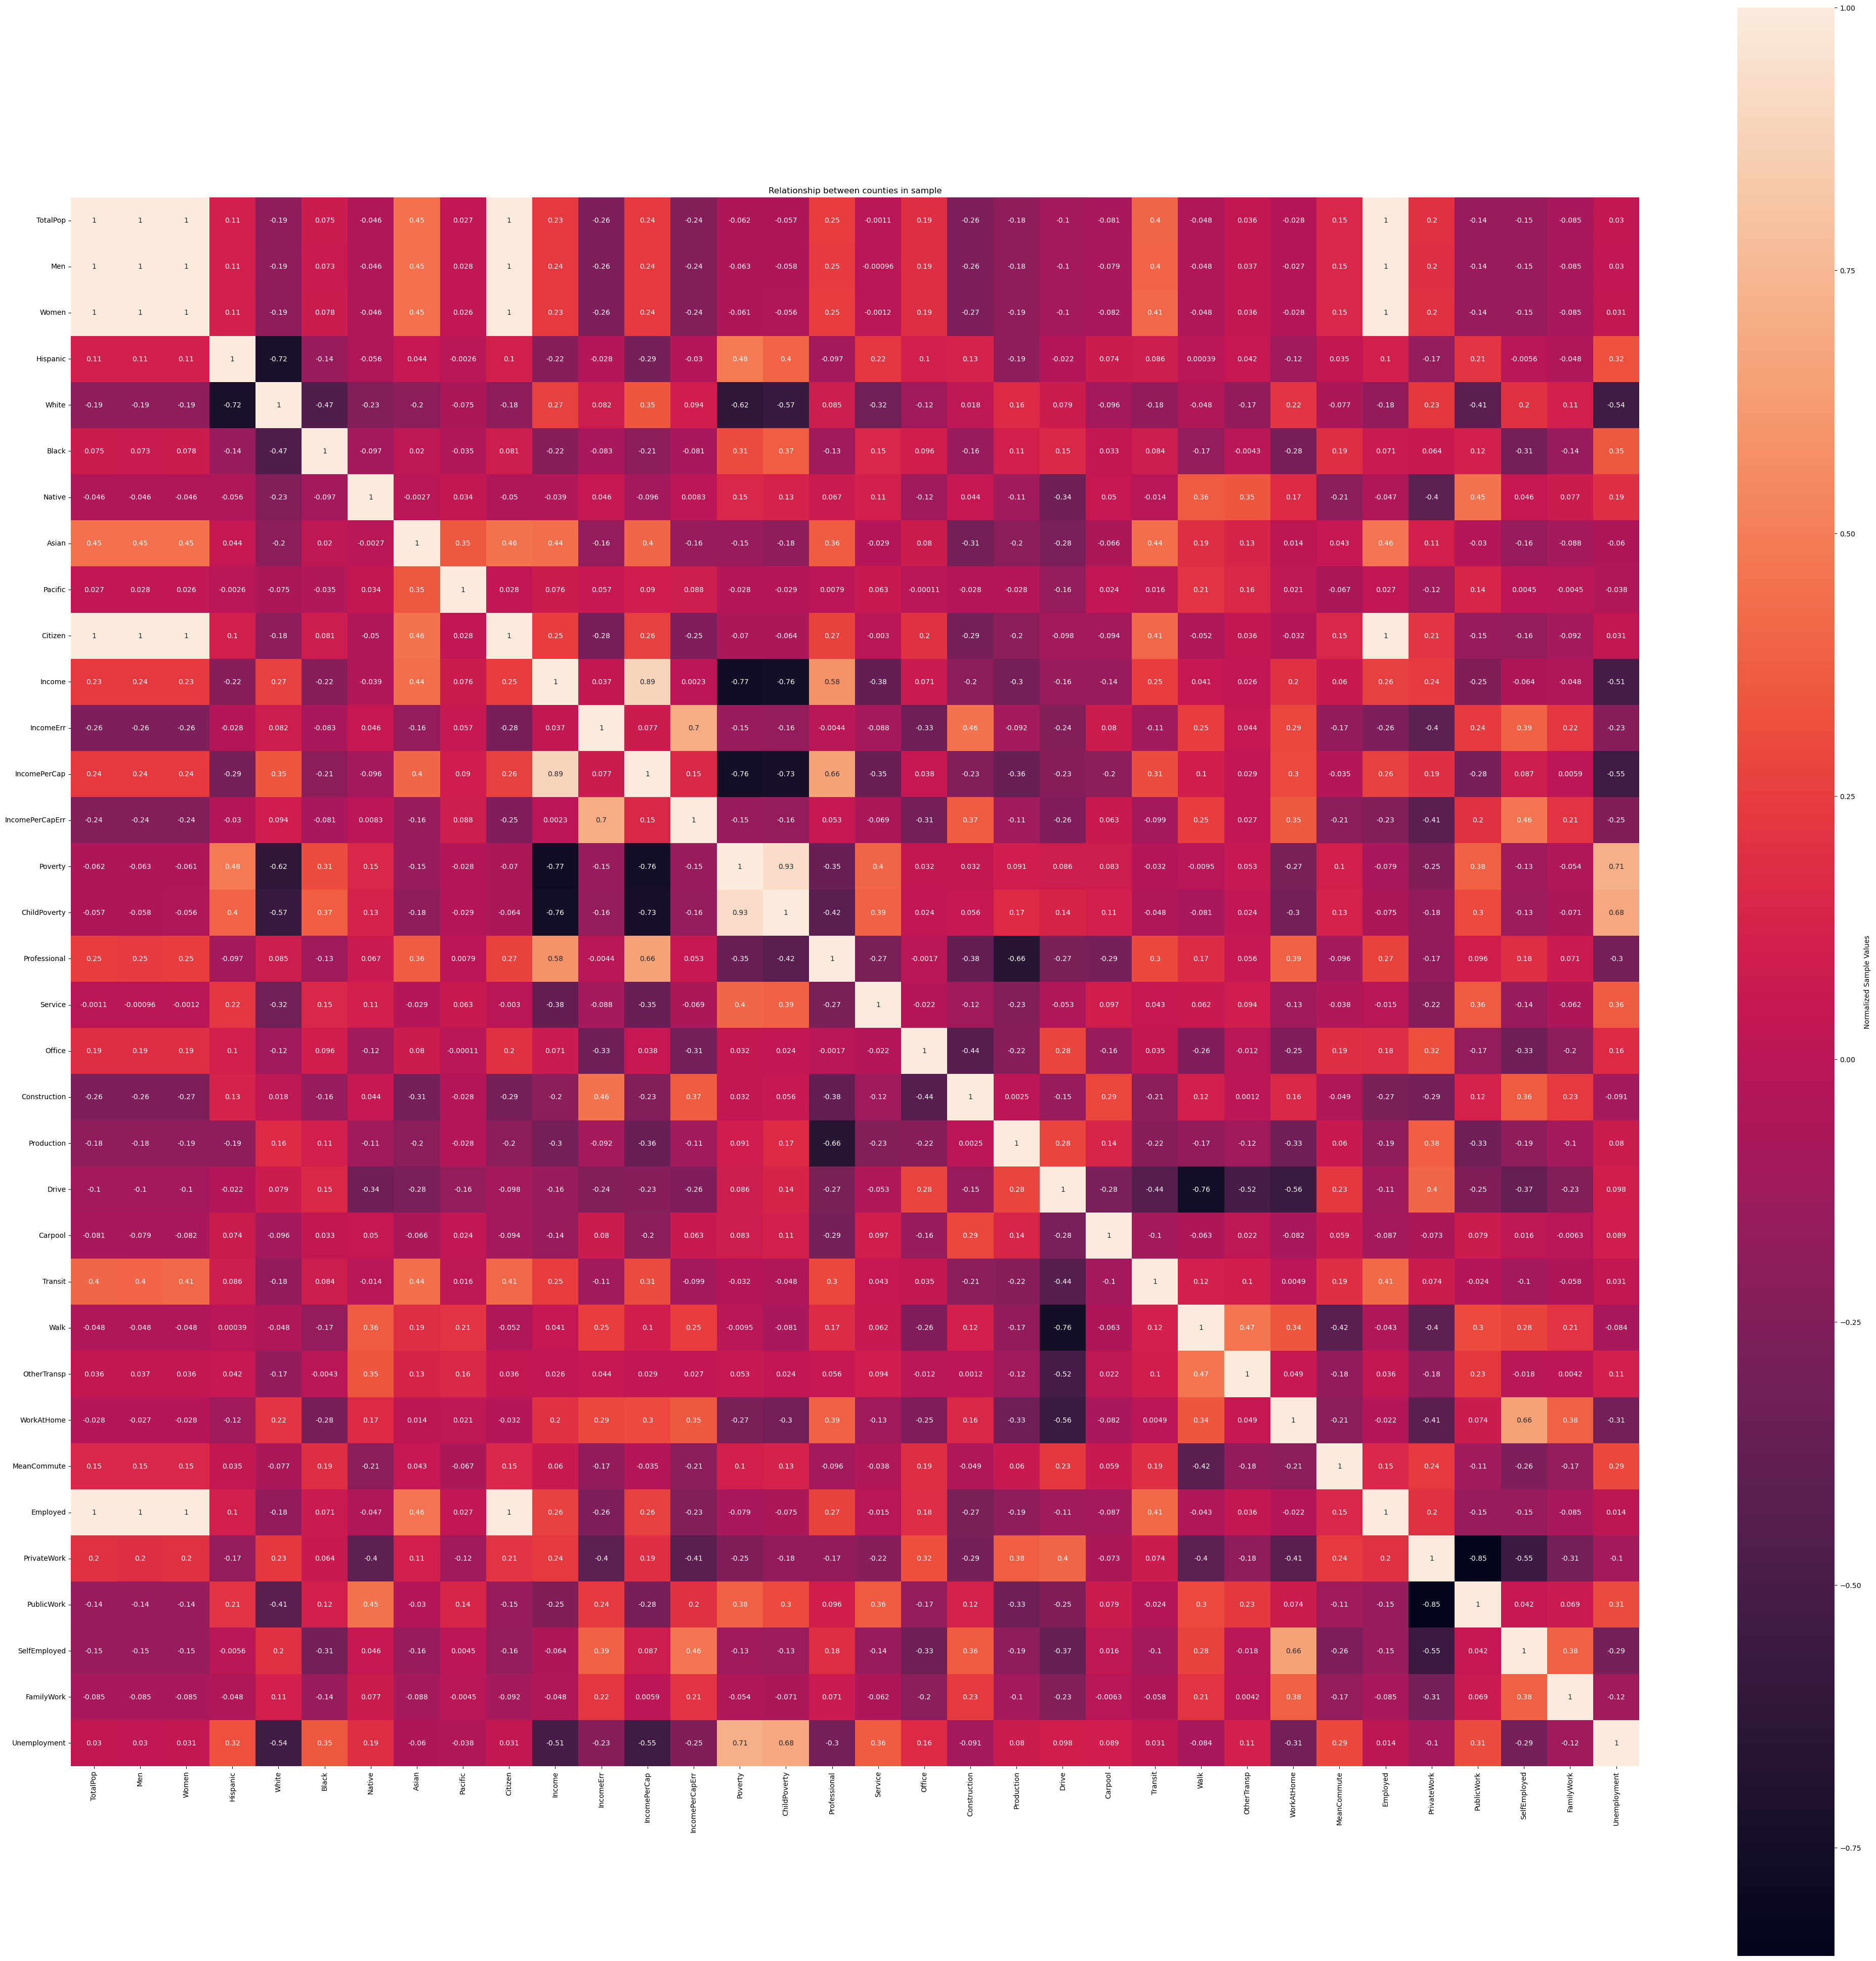

In [15]:
# Using a seaborn heatmap to find correlation between features

import seaborn as sns
plt.figure(figsize=(50, 50))
ax = sns.heatmap((new_data.corr()), annot=True, cbar=True, square=True, \
             cbar_kws={'label': 'Normalized Sample Values'})
plt.title('Relationship between counties in sample')

In [16]:
new_data.corr()

TotalPop       Men     Women  Hispanic     White     Black  \
TotalPop         1.000000  0.999877  0.999886  0.113882 -0.187370  0.075296   
Men              0.999877  1.000000  0.999527  0.114286 -0.186478  0.072807   
Women            0.999886  0.999527  1.000000  0.113466 -0.188187  0.077676   
Hispanic         0.113882  0.114286  0.113466  1.000000 -0.724959 -0.144540   
White           -0.187370 -0.186478 -0.188187 -0.724959  1.000000 -0.466185   
Black            0.075296  0.072807  0.077676 -0.144540 -0.466185  1.000000   
Native          -0.046038 -0.045818 -0.046240 -0.056119 -0.231565 -0.097140   
Asian            0.447874  0.449085  0.446604  0.044244 -0.199347  0.019916   
Pacific          0.027104  0.028143  0.026096 -0.002645 -0.075080 -0.035385   
Citizen          0.996378  0.995819  0.996685  0.104092 -0.183133  0.081138   
Income           0.234883  0.235855  0.233892 -0.219508  0.266947 -0.220584   
IncomeErr       -0.263333 -0.262740 -0.263844 -0.027514  0.082221 -0.083288   
IncomePerCap     0.238516  0.237878  0.239075 -0.294180  0.345323 -0.207272   
IncomePerCapErr -0.235936 -0.235582 -0.236222 -0.029884  0.093692 -0.081191   
Poverty         -0.062075 -0.063009 -0.061161  0.482186 -0.618490  0.308611   
ChildPoverty    -0.057033 -0.058182 -0.055913  0.395246 -0.573629  0.371909   
Professional     0.248403  0.247094  0.249607 -0.097219  0.085386 -0.125293   
Service         -0.001064 -0.000958 -0.001165  0.222669 -0.317807  0.148077   
Office           0.185946  0.185006  0.186808  0.104799 -0.122228  0.095943   
Construction    -0.264243 -0.262402 -0.265956  0.131005  0.017874 -0.157809   
Production      -0.184503 -0.183940 -0.185003 -0.187876  0.161394  0.107941   
Drive           -0.103191 -0.101488 -0.104808 -0.021655  0.078510  0.154946   
Carpool         -0.080850 -0.079179 -0.082440  0.074306 -0.095702  0.032938   
Transit          0.402729  0.396624  0.408516  0.086346 -0.178568  0.083811   
Walk            -0.047901 -0.048278 -0.047526  0.000392 -0.048004 -0.169504   
OtherTransp      0.036125  0.036560  0.035697  0.041738 -0.173506 -0.004333   
WorkAtHome      -0.027852 -0.027384 -0.028297 -0.120975  0.217985 -0.281791   
MeanCommute      0.148545  0.147537  0.149481  0.035312 -0.077046  0.186750   
Employed         0.997621  0.997481  0.997524  0.102515 -0.176872  0.071231   
PrivateWork      0.196913  0.196025  0.197722 -0.170047  0.228257  0.064072   
PublicWork      -0.143553 -0.142667 -0.144373  0.212196 -0.405057  0.115743   
SelfEmployed    -0.146419 -0.146133 -0.146661 -0.005562  0.202066 -0.305339   
FamilyWork      -0.085016 -0.084826 -0.085180 -0.047897  0.112044 -0.137477   
Unemployment     0.030306  0.029516  0.031060  0.321975 -0.538941  0.352578   

                   Native     Asian   Pacific   Citizen  ...      Walk  \
TotalPop        -0.046038  0.447874  0.027104  0.996378  ... -0.047901   
Men             -0.045818  0.449085  0.028143  0.995819  ... -0.048278   
Women           -0.046240  0.446604  0.026096  0.996685  ... -0.047526   
Hispanic        -0.056119  0.044244 -0.002645  0.104092  ...  0.000392   
White           -0.231565 -0.199347 -0.075080 -0.183133  ... -0.048004   
Black           -0.097140  0.019916 -0.035385  0.081138  ... -0.169504   
Native           1.000000 -0.002663  0.033927 -0.050108  ...  0.362889   
Asian           -0.002663  1.000000  0.353935  0.456733  ...  0.187220   
Pacific          0.033927  0.353935  1.000000  0.027806  ...  0.209134   
Citizen         -0.050108  0.456733  0.027806  1.000000  ... -0.051720   
Income          -0.038630  0.439432  0.075974  0.248213  ...  0.040715   
IncomeErr        0.046374 -0.163350  0.057022 -0.282620  ...  0.247857   
IncomePerCap    -0.095884  0.403223  0.090034  0.257302  ...  0.101142   
IncomePerCapErr  0.008278 -0.155552  0.087864 -0.252711  ...  0.252125   
Poverty          0.153093 -0.153620 -0.028188 -0.069567  ... -0.009536   
ChildPoverty     0.128453 -0.182857 -0.028769 -0.064228  ... -0.081

From the heatmap and correlation table above only a few number of features correlate strongly. For instance, the Employed feature has a high level of correlation with the Men, Women, TotalPop and Citizen features, which means that this features can be used to predict each other with a high level of accuracy. The information in the Employed feature could be reconstructed from the Men, Women, TotalPop and Citizen features and therefore a minimal amount of information is lost if the Employed category is removed. The correlations for all three of these combinations are positive and linear with the points in the scatterplot lying roughly along a line with a positive slope. This means that as purchases in one category increase, the purchases in the correlated category tend to increase linearly.

In [17]:
new_data_with_state_county = new_data.reset_index(drop=False)
new_data_with_state_county.rename(columns={'index' : 'State-County'}, inplace=True)


In [18]:
#Creating new column indexed with State-County for sample data
np.random.seed(50)
indices = np.random.randint(0, data.shape[0], 10).tolist()

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(new_data_with_state_county.loc[indices], columns = new_data_with_state_county.keys()).reset_index(drop = True)
print ("Chosen samples of population segment dataset:")
display(samples)

Chosen samples of population segment dataset:


State-County  TotalPop     Men   Women  Hispanic  White  \
0         Nebraska-McPherson       433     223     210       0.9   97.5   
1         Missouri-Christian     80904   39288   41616       2.8   93.7   
2     North Carolina-Halifax     53407   25620   27787       2.6   39.2   
3             Oklahoma-Grant      4517    2228    2289       4.1   89.9   
4       North Dakota-McHenry      5817    3046    2771       2.4   95.3   
5              Arkansas-Drew     18740    9215    9525       2.9   66.9   
6                 Ohio-Stark    374979  181905  193074       1.8   87.2   
7       Pennsylvania-Juniata     24829   12384   12445       2.9   95.2   
8  Alaska-Bethel Census Area     17776    9351    8425       1.8   11.3   
9     Puerto Rico-San Germán     34125   16590   17535      99.6    0.3   

   Black  Native  Asian  Pacific  ...  Walk  OtherTransp  WorkAtHome  \
0    0.0     0.0    0.0      0.0  ...  15.7          4.6        22.6   
1    0.6     0.4    0.6      0.0  ...   0.7          1.5         4.6   
2   51.9     3.2    0.8      0.0  ...   1.8          1.2         1.7   
3    0.4     0.5    0.2      0.0  ...   3.7          1.1         3.3   
4    0.2     0.6    0.2      0.0  ...   7.8          0.6         9.6   
5   28.8     0.1    0.3      0.0  ...   1.8          0.8         2.3   
6    7.1     0.1    0.8      0.0  ...   1.6          0.6         2.8   
7    0.8     0.1    0.4      0.0  ...   3.4          0.9         5.2   
8    0.8    80.6    1.2      0.3  ...  33.0         22.6         4.8   
9    0.1     0.0    0.0      0.0  ...   3.0          0.9         3.7   

   MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
0         32.0       222         69.4         5.9          23.9         0.9   
1         26.3     37578         81.4        12.2           6.3         0.1   
2         23.9     19726         76.7        17.6           5.6         0.1   
3         19.9      2098         64.7        17.5          17.7         0.1   
4         27.2      2840         66.8        13.6          19.4         0.2   
5         22.1      7361         69.9        22.5           7.5         0.1   
6         21.6    174941         84.4        10.2           5.3         0.1   
7         28.8     11152         81.6        11.0           7.2         0.2   
8          7.4      6232         53.2        44.8           2.0         0.0   
9         26.5      8803         67.1        22.7           9.8         0.4   

   Unemployment  
0           0.9  
1           6.4  
2          14.1  
3           3.6  
4           3.1  
5          14.3  
6           8.5  
7           5.7  
8          17.6  
9           6.8  

[10 rows x 35 columns]

In [19]:
#Creating new data without columns State-County for scaling and normalization prposes
new_data_without_state_county = new_data_with_state_county.drop(["State-County"], axis=1)

In [20]:
from scipy.stats import percentileofscore
samples1 = samples.drop(columns = ['State-County'])

percentile_samples = pd.DataFrame()
for item in samples1:
    pct_score = []
    for idx in samples1.index:
        pct_score.append(round((percentileofscore(new_data_without_state_county[item], samples1.loc[idx, item])), 2))
    percentile_samples[item] = pct_score
    
display(percentile_samples)


TotalPop    Men  Women  Hispanic  White  Black  Native  Asian  Pacific  \
0      0.12   0.14   0.12      6.23  98.26   2.97    7.38   5.93    38.12   
1     78.45  77.95  78.70     38.94  77.44  28.11   64.35  55.34    38.12   
2     70.56  69.66  71.24     36.02   8.39  97.42   91.86  64.95    38.12   
3      8.63   8.42   8.91     52.25  63.82  19.61   70.50  23.66    38.12   
4     11.40  11.89  11.27     32.78  86.12  11.97   74.83  23.66    38.12   
5     39.50  38.91  39.81     40.33  28.29  89.63   23.98  31.86    38.12   
6     94.50  94.47  94.53     22.95  57.02  70.78   23.98  64.95    38.12   
7     48.28  48.48  48.48     40.33  85.48  34.04   23.98  40.22    38.12   
8     37.95  39.38  36.30     22.95   2.98  34.04   99.91  75.71    94.69   
9     57.64  57.11  58.48     99.19   1.01   8.01    7.38   5.93    38.12   

   Citizen  ...   Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0     0.19  ...  98.88        97.24       99.66        93.32      0.23   
1    77.89  ...   6.26        59.70       60.85        72.53     79.32   
2    71.15  ...  36.12        44.05        7.92        56.55     66.89   
3     8.70  ...  71.15        38.48       37.41        27.52      9.72   
4    11.86  ...  93.80        12.30       94.32        77.00     14.32   
5    40.28  ...  36.12        20.96       16.60        43.25     38.85   
6    94.78  ...  30.23        12.30       26.72        39.52     94.53   
7    48.51  ...  67.24        26.21       69.72        83.93     51.68   
8    32.33  ...  99.69        99.91       64.19         0.23     33.57   
9    59.16  ...  61.60        26.21       45.30        73.62     44.30   

   PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  
0        21.41        0.06         99.25       94.41          0.79  
1        84.44       18.04         41.37       30.99         34.69  
2        56.43       59.61         29.15       30.99         93.85  
3        10.95       58.94         96.94       30.99          9.70  
4        15.16       29.19         98.17       54.77          7.13  
5        22.87       83.14         57.36       30.99         94.18  
6        95.56        5.51         24.10       30.99         60.92  
7        85.34        9.25         54.05       54.77         27.02  
8         2.17       99.53          0.34        8.90         97.20  
9        15.71       83.70         77.62       79.63         39.78  

[10 rows x 34 columns]

Calculating the median values to for relative comparison 

In [21]:
added_columns = ['State-County', 'CensusId']
percentile_samples['State-County'] = samples['State-County'][:percentile_samples.shape[0]]
# percentile_samples['CensusId'] = samples['CensusId'][:percentile_samples.shape[0]]

percentile_samples


TotalPop    Men  Women  Hispanic  White  Black  Native  Asian  Pacific  \
0      0.12   0.14   0.12      6.23  98.26   2.97    7.38   5.93    38.12   
1     78.45  77.95  78.70     38.94  77.44  28.11   64.35  55.34    38.12   
2     70.56  69.66  71.24     36.02   8.39  97.42   91.86  64.95    38.12   
3      8.63   8.42   8.91     52.25  63.82  19.61   70.50  23.66    38.12   
4     11.40  11.89  11.27     32.78  86.12  11.97   74.83  23.66    38.12   
5     39.50  38.91  39.81     40.33  28.29  89.63   23.98  31.86    38.12   
6     94.50  94.47  94.53     22.95  57.02  70.78   23.98  64.95    38.12   
7     48.28  48.48  48.48     40.33  85.48  34.04   23.98  40.22    38.12   
8     37.95  39.38  36.30     22.95   2.98  34.04   99.91  75.71    94.69   
9     57.64  57.11  58.48     99.19   1.01   8.01    7.38   5.93    38.12   

   Citizen  ...  OtherTransp  WorkAtHome  MeanCommute  Employed  PrivateWork  \
0     0.19  ...        97.24       99.66        93.32      0.23        21.41   
1    77.89  ...        59.70       60.85        72.53     79.32        84.44   
2    71.15  ...        44.05        7.92        56.55     66.89        56.43   
3     8.70  ...        38.48       37.41        27.52      9.72        10.95   
4    11.86  ...        12.30       94.32        77.00     14.32        15.16   
5    40.28  ...        20.96       16.60        43.25     38.85        22.87   
6    94.78  ...        12.30       26.72        39.52     94.53        95.56   
7    48.51  ...        26.21       69.72        83.93     51.68        85.34   
8    32.33  ...        99.91       64.19         0.23     33.57         2.17   
9    59.16  ...        26.21       45.30        73.62     44.30        15.71   

   PublicWork  SelfEmployed  FamilyWork  Unemployment  \
0        0.06         99.25       94.41          0.79   
1       18.04         41.37       30.99         34.69   
2       59.61         29.15       30.99         93.85   
3       58.94         96.94       30.99          9.70   
4       29.19         98.17       54.77          7.13   
5       83.14         57.36       30.99         94.18   
6        5.51         24.10       30.99         60.92   
7        9.25         54.05       54.77         27.02   
8       99.53          0.34        8.90         97.20   
9       83.70         77.62       79.63         39.78   

                State-County  
0         Nebraska-McPherson  
1         Missouri-Christian  
2     North Carolina-Halifax  
3             Oklahoma-Grant  
4       North Dakota-McHenry  
5              Arkansas-Drew  
6                 Ohio-Stark  
7       Pennsylvania-Juniata  
8  Alaska-Bethel Census Area  
9     Puerto Rico-San Germán  

[10 rows x 35 columns]

In [22]:
median_values = pd.DataFrame([np.median(new_data_without_state_county\
                                        [new_data_without_state_county.columns.values[i]])\
                              for i in range(len(new_data_without_state_county.columns.values))]).reset_index(drop=True)
median_values.iloc[0]
median_values.index = new_data_without_state_county.columns.values
median_values.columns = ['Median_Values']
median_values

Median_Values
TotalPop              26035.00
Men                   12932.00
Women                 13057.00
Hispanic                  3.90
White                    84.10
Black                     1.90
Native                    0.30
Asian                     0.50
Pacific                   0.00
Citizen               19643.00
Income                44749.50
IncomeErr              2406.50
IncomePerCap          23460.00
IncomePerCapErr        1096.50
Poverty                  16.15
ChildPoverty             22.70
Professional             29.90
Service                  18.10
Office                   22.40
Construction             12.10
Production               15.25
Drive                    80.70
Carpool                   9.90
Transit                   0.40
Walk                      2.40
OtherTransp               1.30
WorkAtHome                3.90
MeanCommute              23.00
Employed              10508.00
PrivateWork              75.70
PublicWork               16.20
SelfEmployed              6.90
FamilyWork                0.20
Unemployment              7.60

My analysis is based primarily on the percentiles displayed above. These percentages represent the feature quantity of the sample State-County relative to all State_county quantity within a specific category (as an example, 30% in the Men category means that a particular state-county has more Men than 30% of total state counties).

Sample 0: Based on the table above, the state-county is below the median value in TotalPop, Men, Women, Employed etc. This could indicate that the State-County may be mainly residential. Probably an estate with parks and a low level of industrialization. This is supported by the 99.66 percentile score on  WorkAtHome individuals.

Sample 6: This state-County is has a high percentile score on TotalPop, Men, Women, Native, White, Black among the rest, this indicates a large city with a lot pf activities and population with more of its population working outside their homes unlike Sample 0. There is also a high level of industrialization due to the large employment rate.

# Feature Relevance

In [23]:
feature_relevant_data_x = new_data_without_state_county.drop('Employed', axis=1)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_relevant_data_x, new_data_without_state_county['Employed'], \
                                                    test_size=0.25, random_state=42)

from sklearn.tree import DecisionTreeRegressor
# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)


# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print(score)

0.9769070676048544


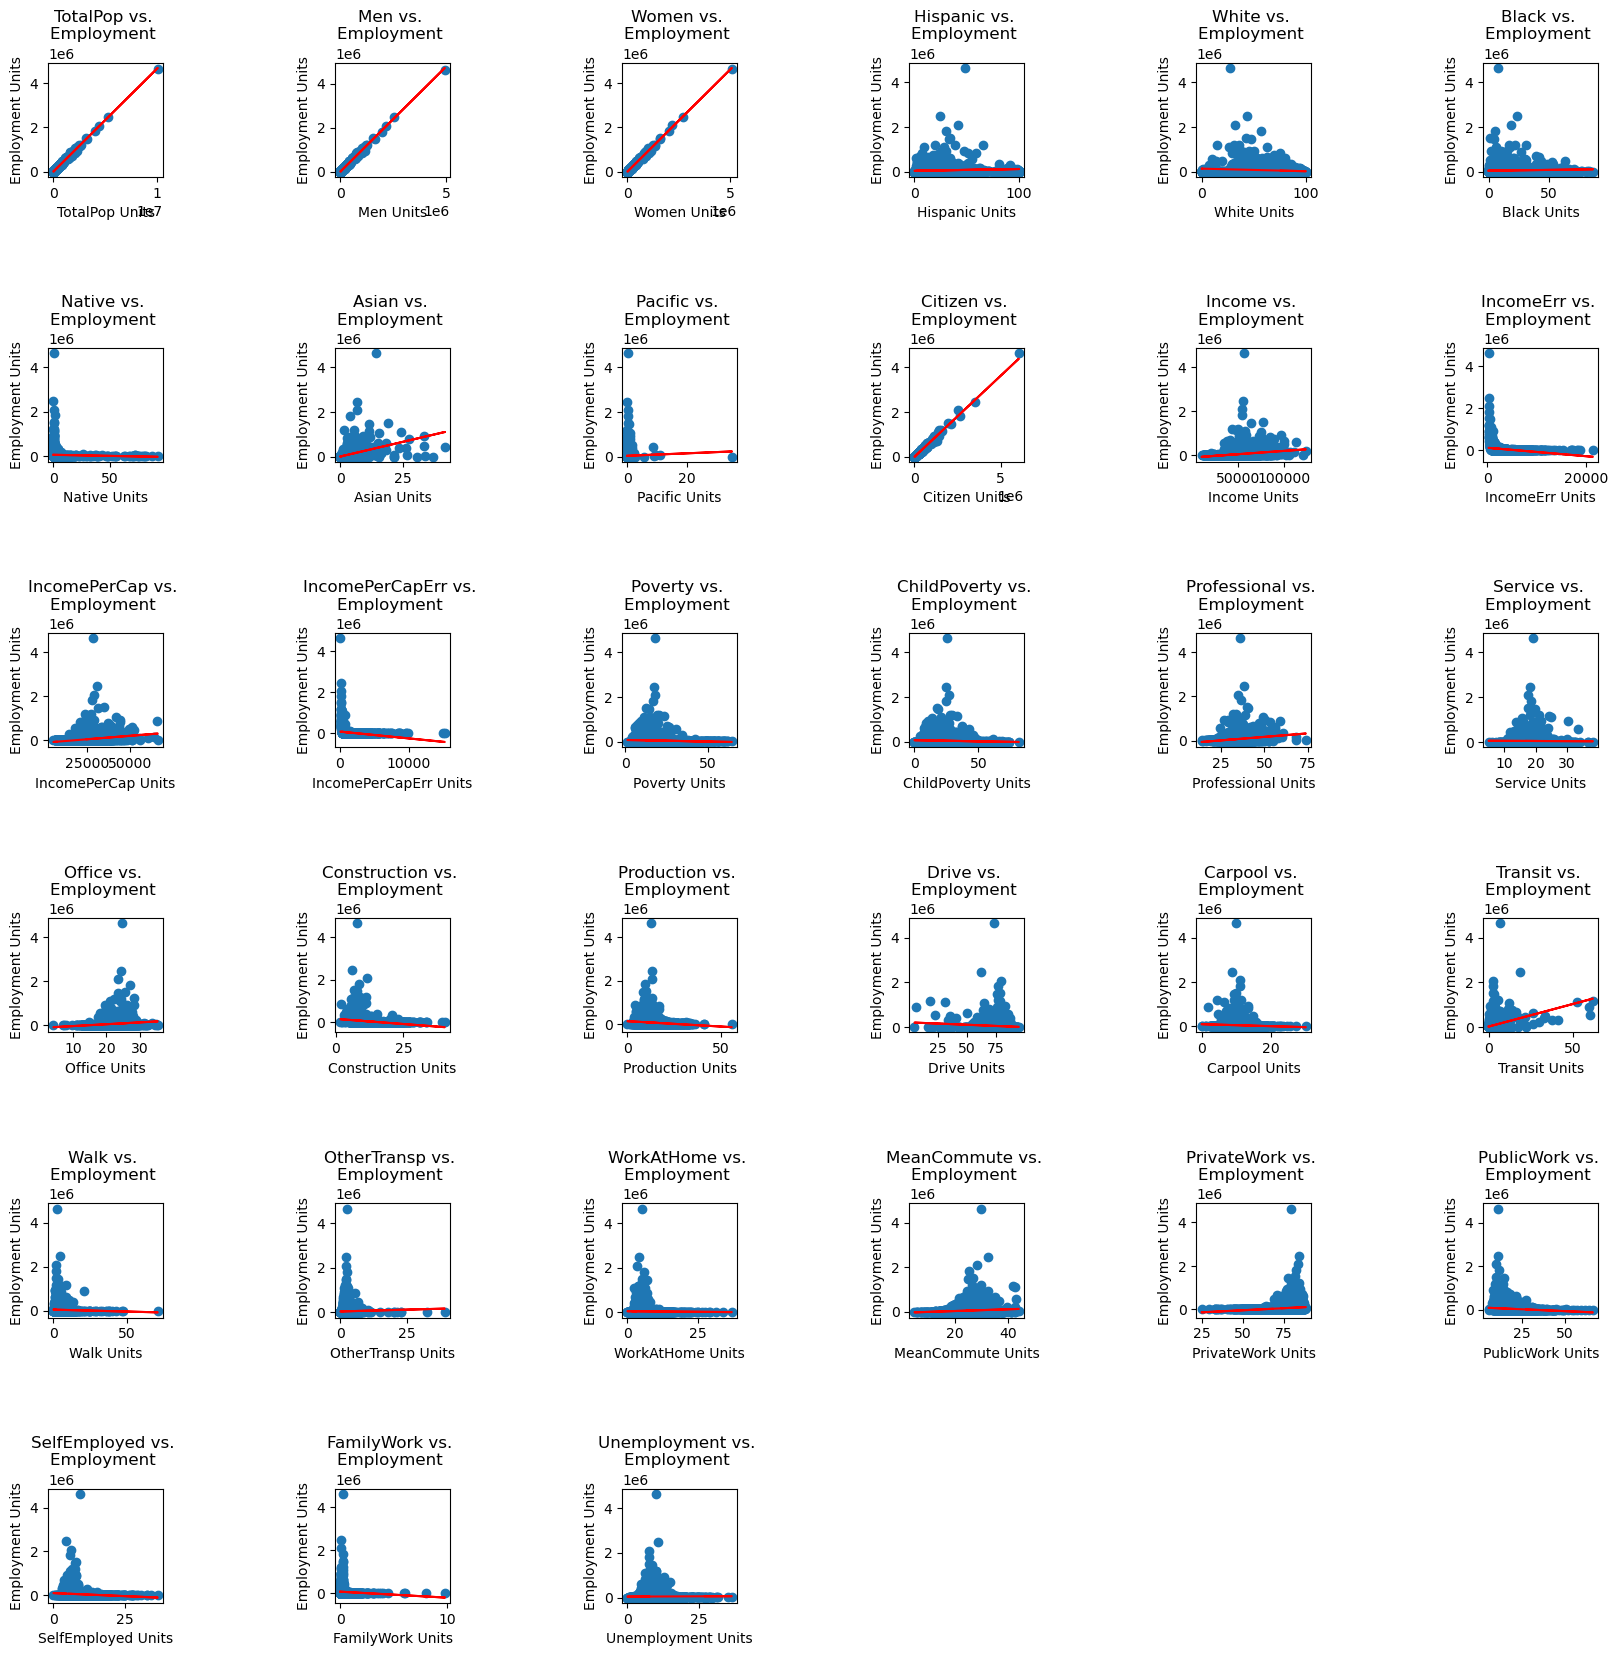

In [24]:
# Plot all categories vs Grocery purchases with trend line
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=1.5)
fig.subplots_adjust(wspace=1.5)

for i, item in enumerate(feature_relevant_data_x):
    z = np.polyfit(feature_relevant_data_x[item], new_data_without_state_county['Employed'], 1)
    p = np.poly1d(z)
    plt.subplot(6,6,i+1)
    plt.scatter(x=feature_relevant_data_x[item], y=new_data_without_state_county['Employed'])
    plt.plot(feature_relevant_data_x[item], p(feature_relevant_data_x[item]), "r-")
    plt.xlabel(item +  ' Units'), plt.ylabel('Employment Units'), plt.title(item +  ' vs. \nEmployment ')

In [25]:
from scipy.stats import pearsonr

for column in feature_relevant_data_x:
    correlation_coef = pearsonr(feature_relevant_data_x[column], new_data_without_state_county['Employed'])[0]
    print("Employment and " + column + " R^2 value = {:.4f}".format(np.square(correlation_coef)))

Employment and TotalPop R^2 value = 0.9952
Employment and Men R^2 value = 0.9950
Employment and Women R^2 value = 0.9951
Employment and Hispanic R^2 value = 0.0105
Employment and White R^2 value = 0.0313
Employment and Black R^2 value = 0.0051
Employment and Native R^2 value = 0.0022
Employment and Asian R^2 value = 0.2145
Employment and Pacific R^2 value = 0.0007
Employment and Citizen R^2 value = 0.9904
Employment and Income R^2 value = 0.0664
Employment and IncomeErr R^2 value = 0.0679
Employment and IncomePerCap R^2 value = 0.0700
Employment and IncomePerCapErr R^2 value = 0.0543
Employment and Poverty R^2 value = 0.0062
Employment and ChildPoverty R^2 value = 0.0056
Employment and Professional R^2 value = 0.0727
Employment and Service R^2 value = 0.0002
Employment and Office R^2 value = 0.0324
Employment and Construction R^2 value = 0.0738
Employment and Production R^2 value = 0.0363
Employment and Drive R^2 value = 0.0121
Employment and Carpool R^2 value = 0.0076
Employment and T

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

def get_r2_for_individual_features(data, feature):
    X = data.drop(feature, axis=1)
    Y = data[feature]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    regressor = DecisionTreeRegressor().fit(X_train, Y_train)
    
    score = regressor.score(X_test, Y_test)
    
    return score

def r2_mean(data, feature, runs=200):
    result = round(np.array([get_r2_for_individual_features(data, feature) for _ in range(runs)]).mean(), 4)
    return result
for column in new_data_without_state_county:
    print("{0:17} {1}".format(column + " R^2 score with all other features: ",\
                              r2_mean(new_data_without_state_county,column)))

TotalPop R^2 score with all other features:  0.9706
Men R^2 score with all other features:  0.9775
Women R^2 score with all other features:  0.972
Hispanic R^2 score with all other features:  0.9652
White R^2 score with all other features:  0.9612
Black R^2 score with all other features:  0.922
Native R^2 score with all other features:  0.38
Asian R^2 score with all other features:  0.5917
Pacific R^2 score with all other features:  -5.9842
Citizen R^2 score with all other features:  0.957
Income R^2 score with all other features:  0.8099
IncomeErr R^2 score with all other features:  0.3079
IncomePerCap R^2 score with all other features:  0.7903
IncomePerCapErr R^2 score with all other features:  0.2975
Poverty R^2 score with all other features:  0.8751
ChildPoverty R^2 score with all other features:  0.7886
Professional R^2 score with all other features:  0.7071
Service R^2 score with all other features:  0.1215
Office R^2 score with all other features:  0.1109
Construction R^2 score 

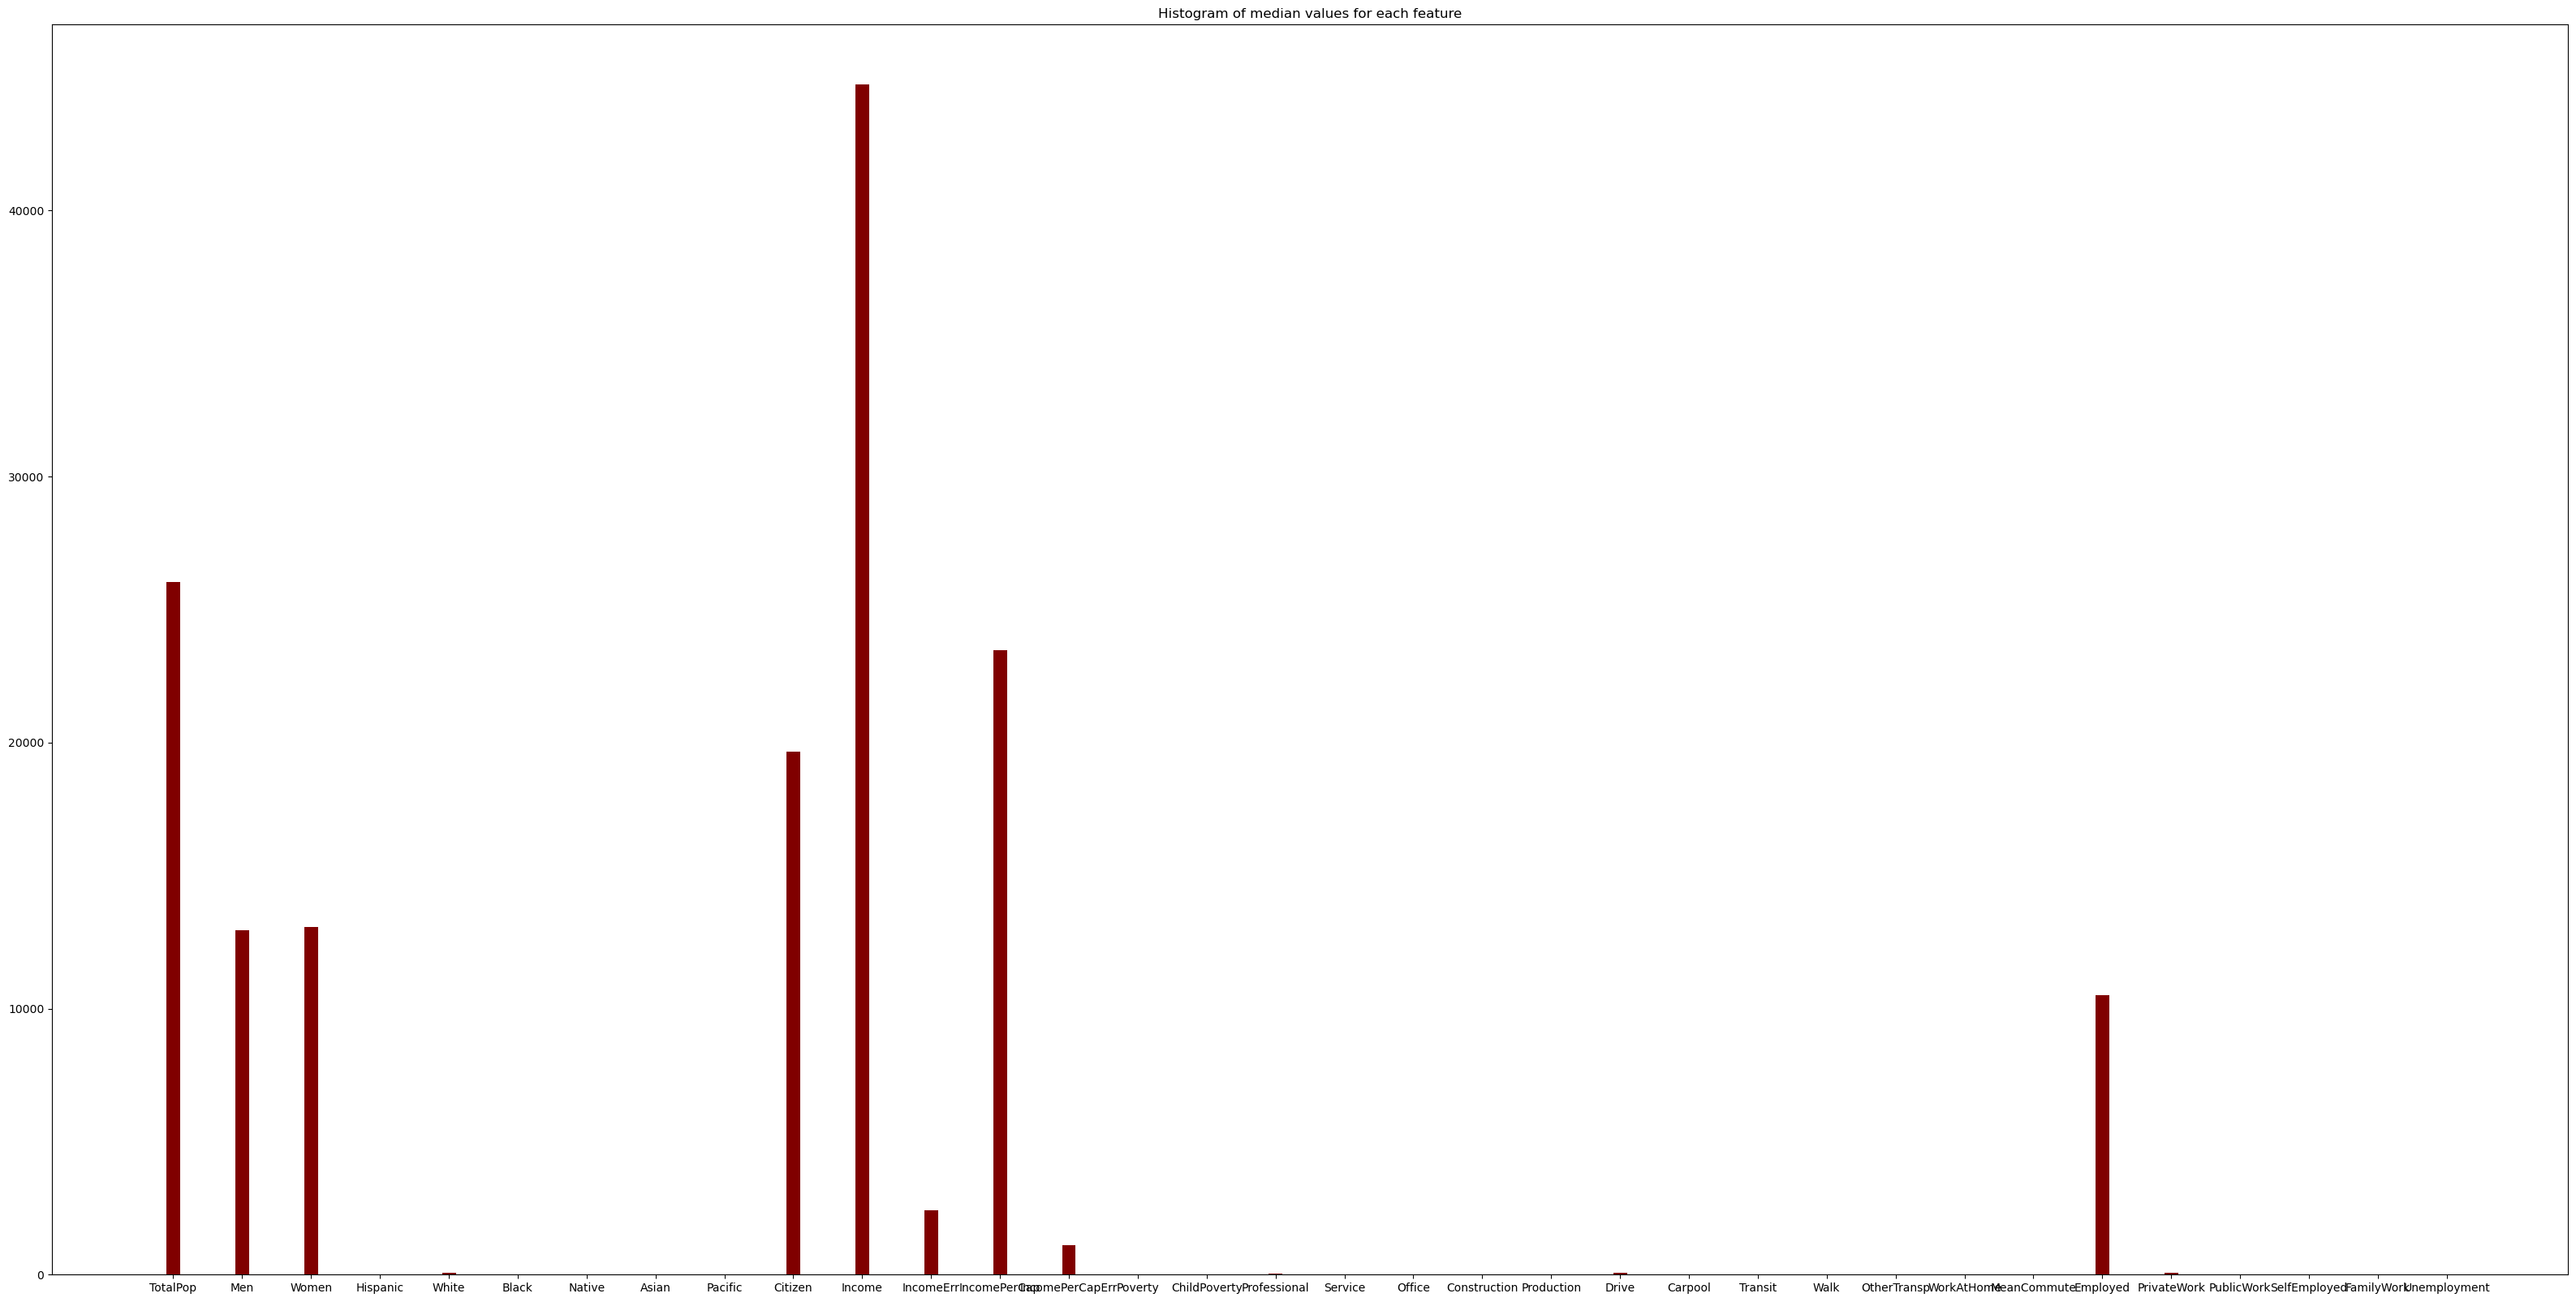

In [27]:

# ax=plt.subplots(figsize=(6,3))
# # get data by column_name and display a histogram
# ax = plt.bar(median_values, height=50)
# title="Histogram of median values for each feature"
# plt.title(title, fontsize=12)
# plt.show()
median_values_keys = [i for i in median_values.index]
median_values_values = [ median_values.loc[idx_name][0] for idx_name in median_values.index]
# median_values_values

ax=plt.subplots(figsize=(40,20))
# get data by column_name and display a histogram
ax = plt.bar(median_values_keys, median_values_values, color='maroon', width=0.2)
title="Histogram of median values for each feature"
plt.title(title, fontsize=12)
plt.show()


# Feature Scaling and Data Preprocessing

If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most often appropriate to apply a non-linear scaling. A simple approach which can work in most cases would be applying the natural logarithm.

In [38]:
log_data = np.log((new_data_without_state_county)**(1/4) +1)
# pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (20,12), diagonal = 'kde')
log_samples = np.log(samples1**(1/4) +1)
log_samples

TotalPop       Men     Women  Hispanic     White     Black    Native  \
0  1.715895  1.581933  1.570022  0.680064  1.421257  0.000000  0.000000   
1  2.882857  2.713288  2.726732  0.830109  1.413727  0.631331  0.585156   
2  2.785132  2.613855  2.632681  0.819702  1.253391  1.304015  0.849074   
3  2.218996  2.063102  2.069000  0.884994  1.405904  0.585156  0.610253   
4  2.275546  2.131682  2.110863  0.808557  1.416932  0.512069  0.631331   
5  2.541616  2.379333  2.386841  0.835066  1.350651  1.198935  0.446186   
6  3.248272  3.075096  3.089310  0.769317  1.400155  0.967879  0.446186   
7  2.606591  2.446607  2.447729  0.835066  1.416733  0.665643  0.446186   
8  2.529459  2.382657  2.359022  0.769317  1.041496  0.665643  1.385366   
9  2.680441  2.513584  2.526319  1.425301  0.553933  0.446186  0.000000   

      Asian   Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0  0.000000  0.000000  1.667184  ...  1.095460     0.901989    1.156993   
1  0.631331  0.000000  2.807742  ...  0.649556     0.745114    0.901989   
2  0.665643  0.000000  2.724322  ...  0.769317     0.716197    0.761674   
3  0.512069  0.000000  2.159047  ...  0.870003     0.705132    0.853483   
4  0.512069  0.000000  2.216366  ...  0.982521     0.631331    1.015312   
5  0.553933  0.000000  2.480530  ...  0.769317     0.665643    0.802671   
6  0.665643  0.000000  3.185763  ...  0.753622     0.631331    0.830109   
7  0.585156  0.000000  2.543854  ...  0.857774     0.680064    0.920316   
8  0.716197  0.553933  2.425609  ...  1.222828     1.156993    0.908325   
9  0.000000  0.000000  2.623738  ...  0.839874     0.680064    0.870003   

   MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
0     1.217406  1.581040     1.357455    0.939430      1.166599    0.680064   
1     1.183133  2.702905     1.387218    1.053935      0.949451    0.446186   
2     1.166599  2.553432     1.376084    1.114560      0.931503    0.446186   
3     1.135296  2.049995     1.344464    1.113603      1.115512    0.446186   
4     1.188976  2.116269     1.350374    1.071710      1.130983    0.512069   
5     1.153162  2.328509     1.358788    1.156233      0.976398    0.446186   
6     1.149250  3.065790     1.394014    1.025003      0.923183    0.446186   
7     1.198935  2.422706     1.387678    1.037148      0.970049    0.512069   
8     0.974307  2.291017     1.308525    1.277355      0.783539    0.000000   
9     1.184447  2.368962     1.351204    1.157749      1.018602    0.585156   

   Unemployment  
0      0.680064  
1      0.951867  
2      1.077655  
3      0.866028  
4      0.844540  
5      1.079979  
6      0.996017  
7      0.934187  
8      1.114560  
9      0.961200  

[10 rows x 34 columns]

# Data before logarithmic scaling

The density plot of the raw data before scaling is seen to be very skewed during to the high deviation from the normal gaussian curve. Although some features curves are fairly Gaussian and distributed such as Carpool, MeanCommute etc

started


C:\Users\OMO_MUSHIN\AppData\Local\Temp\ipykernel_9092\823142741.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(figsize=(3,3))


stopped


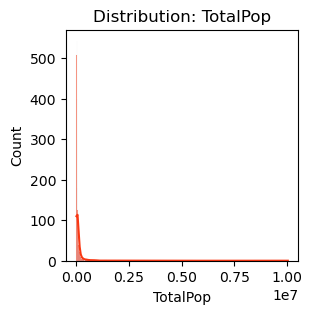

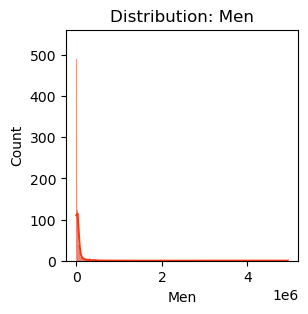

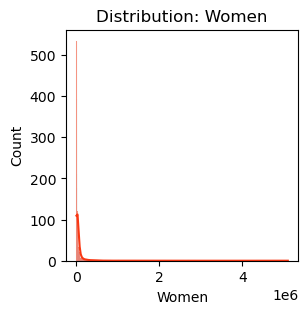

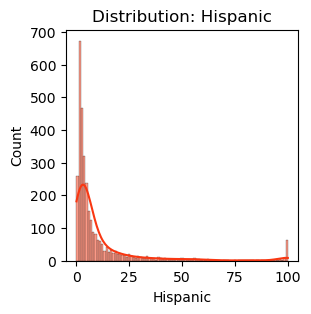

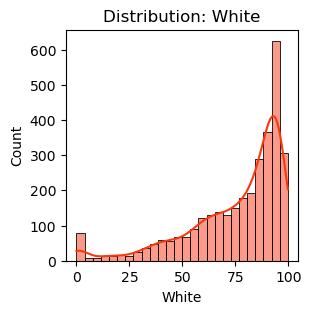

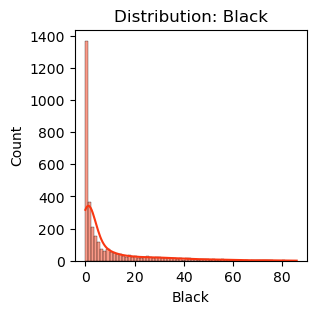

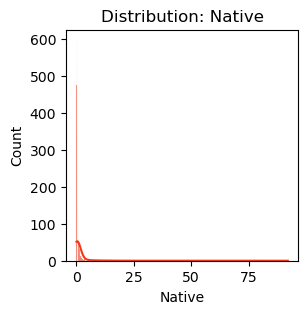

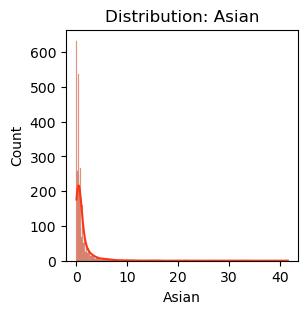

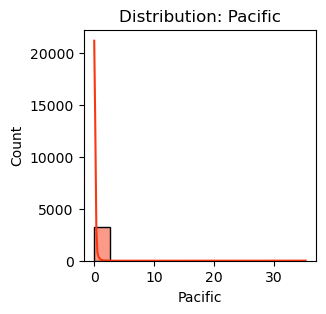

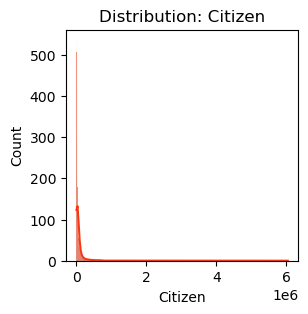

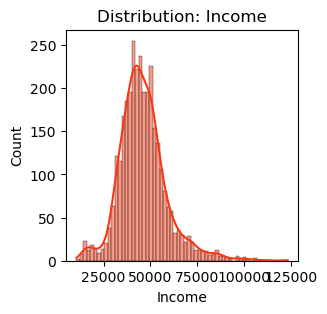

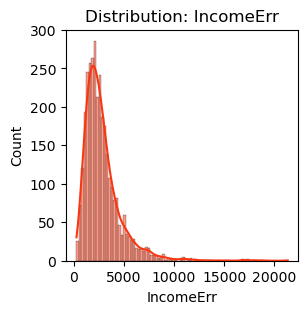

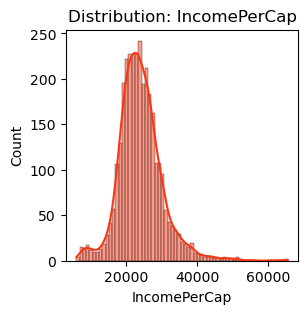

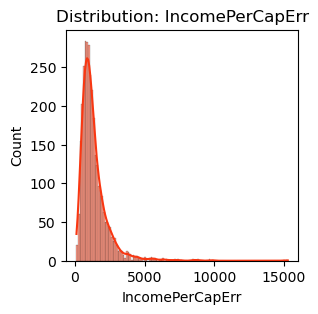

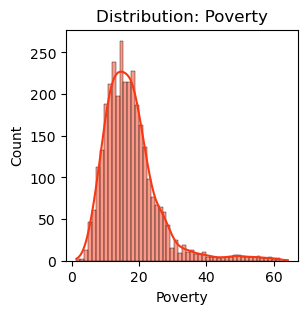

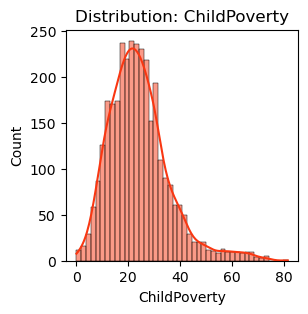

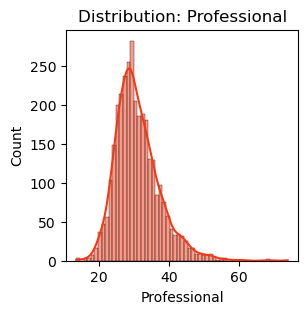

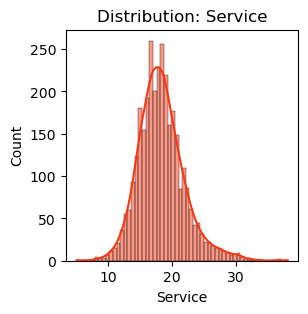

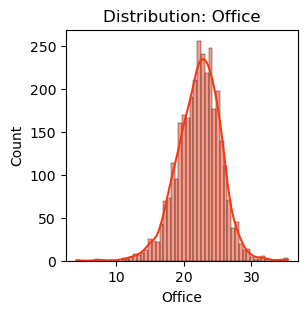

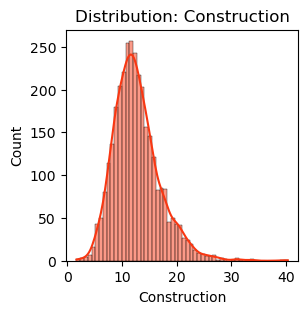

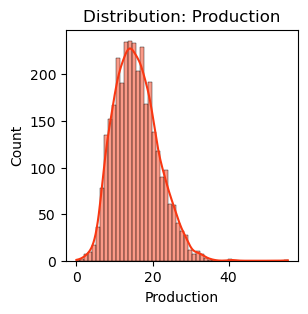

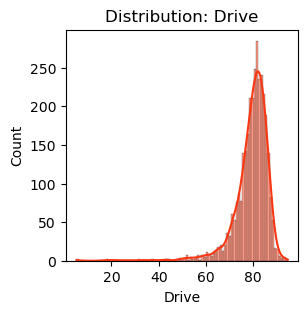

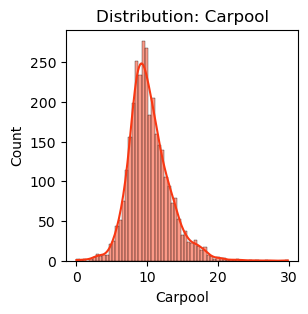

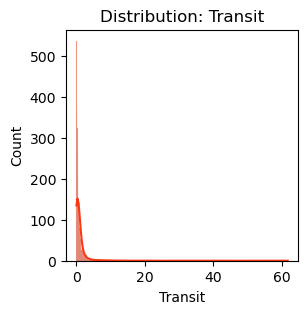

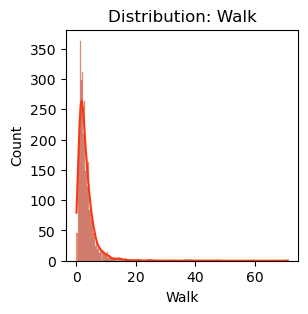

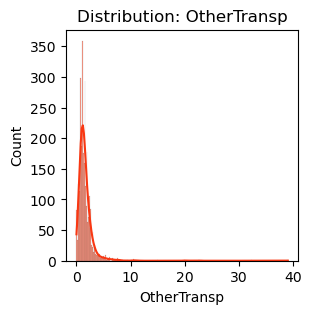

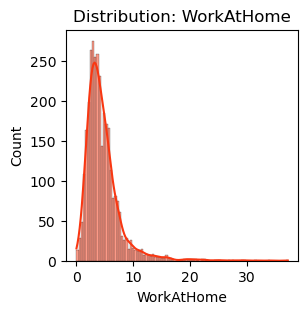

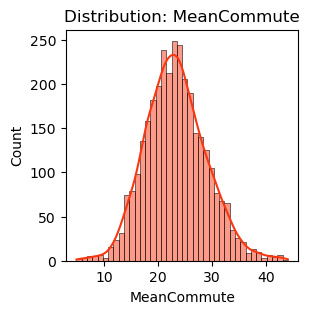

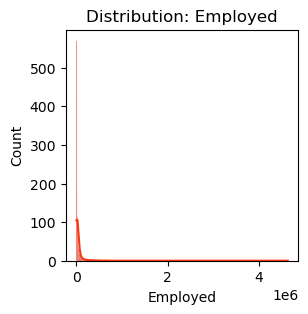

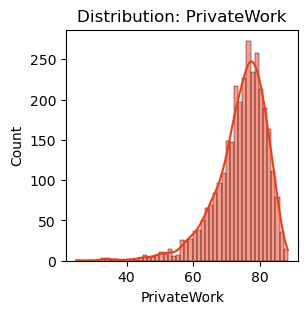

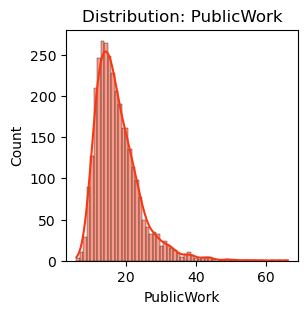

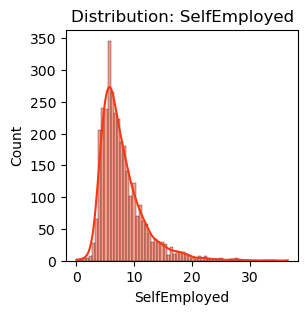

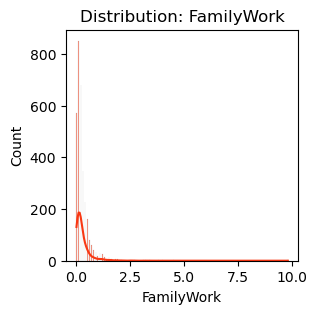

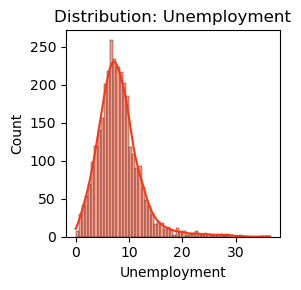

In [40]:

hue_color = '#F93712'
print('started')


for col in log_data.columns.values:
    fig, axes = plt.subplots(figsize=(3,3))
    
    sns.histplot(new_data_without_state_county[col],kde=True,color=hue_color)
    axes.set_xlabel(col)
    axes.set_title('Distribution: {}'.format(col))
    
plt.tight_layout()    
print('stopped')

# Data after logarithmic Scaling

After scaling, it can be observed that most of the features are Gaussian with minimum skewness. This can be seen from the close similarity of mos of the curves with the normal gaussian probability curves

started


C:\Users\OMO_MUSHIN\AppData\Local\Temp\ipykernel_9092\1191762257.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(figsize=(3,3))


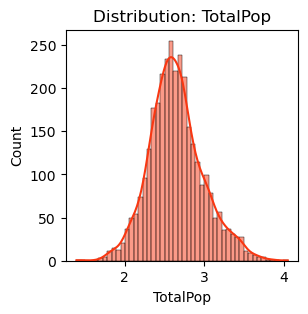

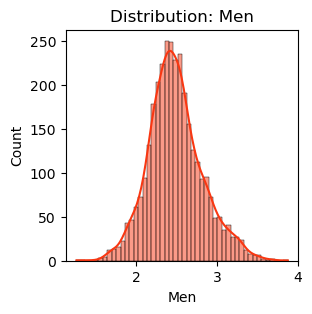

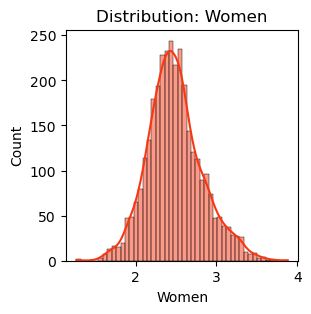

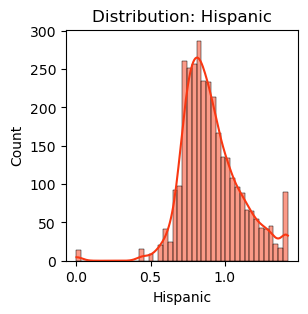

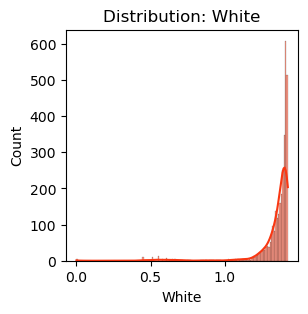

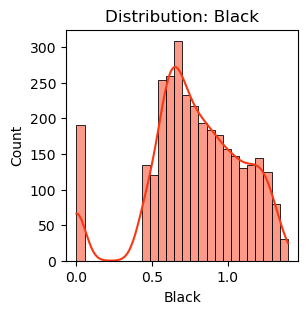

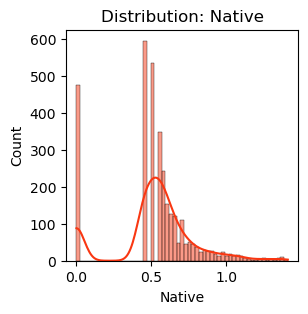

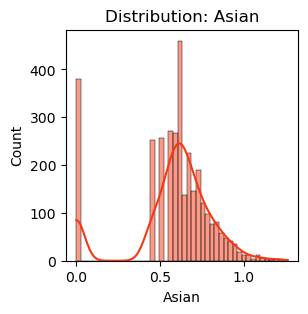

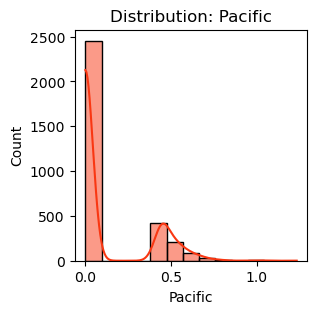

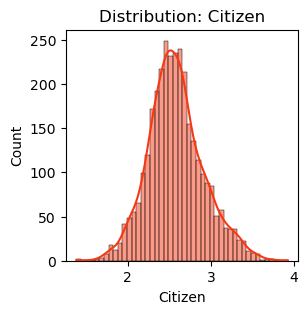

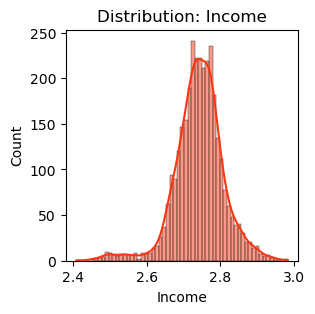

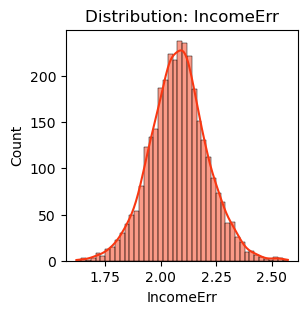

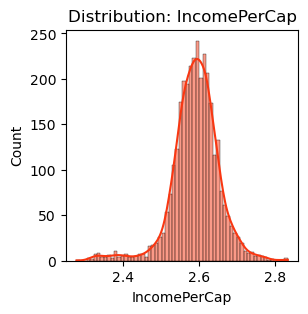

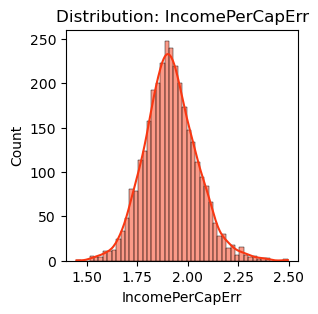

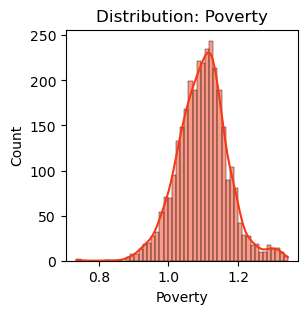

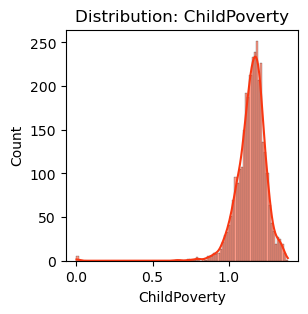

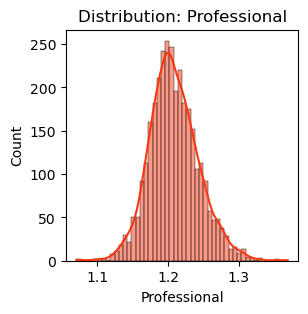

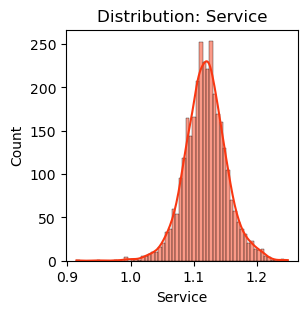

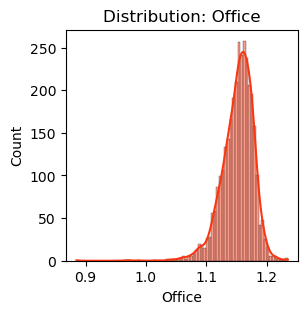

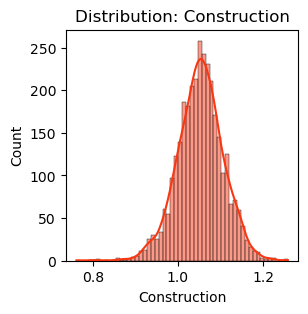

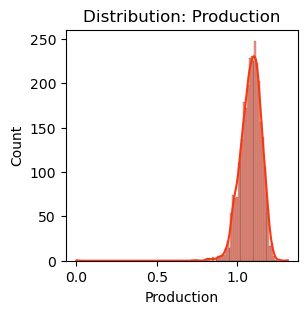

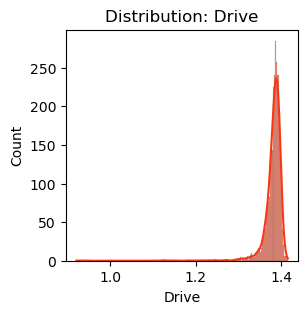

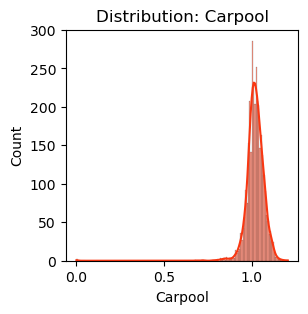

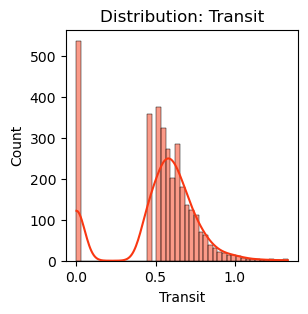

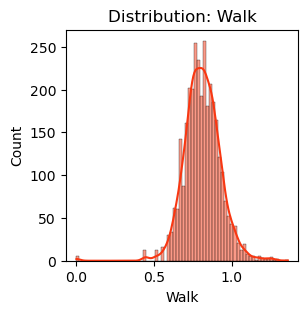

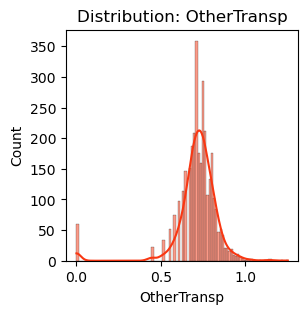

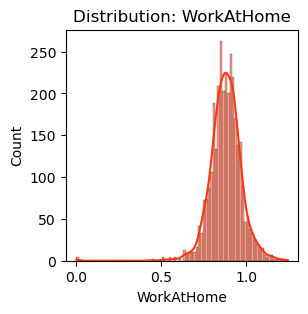

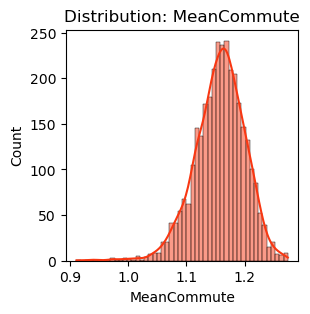

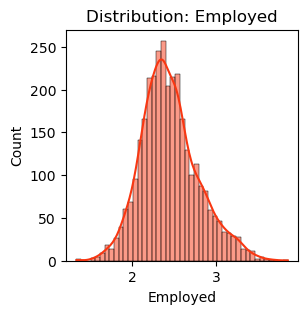

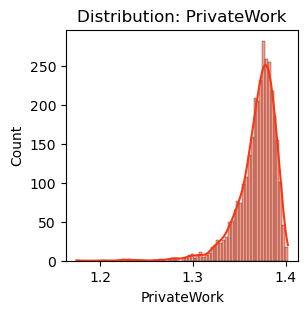

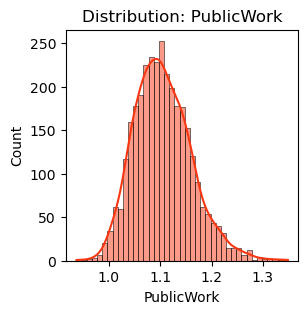

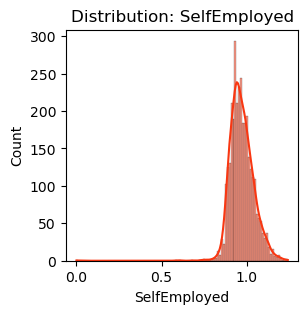

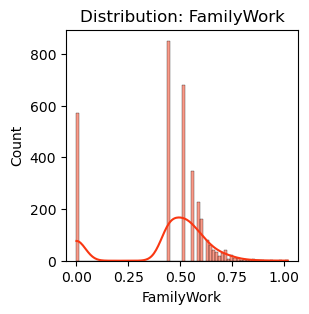

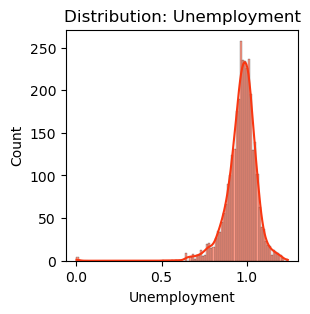

stopped


In [41]:
hue_color = '#F93712'
print('started')

# fig, axes = plt.subplots(2, 3)
# axes = axes.flatten()
# fig.set_size_inches(16,10)
# fig.subplots_adjust(wspace=0.5)
# fig.suptitle('Distribution of Purchase Categories After Scaling\n\n red: median; blue: mean')

for col in log_data.columns.values:
    fig, axes = plt.subplots(figsize=(3,3))
    
    sns.histplot(log_data[col],kde=True,color=hue_color)
    axes.set_xlabel(col)
    axes.set_title('Distribution: {}'.format(col))
    
plt.show()   
print('stopped')

Checking the relevance if the Employed feature after logarithmic scaling.
It appears there is still a fairly approximate correlation of the Employed feature after the data has been scaled with the data before scaling.

In [48]:
from scipy.stats import pearsonr

for column in feature_relevant_data_x:
    correlation_coef = pearsonr(log_data[column], log_data['Employed'])[0]
    print("Employment and " + column + " R^2 value = {:.4f}".format(np.square(correlation_coef)))

Employment and TotalPop R^2 value = 0.9866
Employment and Men R^2 value = 0.9850
Employment and Women R^2 value = 0.9870
Employment and Hispanic R^2 value = 0.0501
Employment and White R^2 value = 0.0003
Employment and Black R^2 value = 0.1498
Employment and Native R^2 value = 0.0021
Employment and Asian R^2 value = 0.3570
Employment and Pacific R^2 value = 0.0183
Employment and Citizen R^2 value = 0.9834
Employment and Income R^2 value = 0.1398
Employment and IncomeErr R^2 value = 0.6131
Employment and IncomePerCap R^2 value = 0.1037
Employment and IncomePerCapErr R^2 value = 0.6460
Employment and Poverty R^2 value = 0.0145
Employment and ChildPoverty R^2 value = 0.0006
Employment and Professional R^2 value = 0.0886
Employment and Service R^2 value = 0.0005
Employment and Office R^2 value = 0.2219
Employment and Construction R^2 value = 0.3594
Employment and Production R^2 value = 0.0174
Employment and Drive R^2 value = 0.0184
Employment and Carpool R^2 value = 0.0032
Employment and T

# Outliers Detection

The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. The method used in this analysis is the InterQuartile Method.
An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [100]:
# # For each feature find the data points with extreme high or low values
# outlier_dict = {}
# for feature in log_data.columns.values:
    
#     Q1 = np.percentile(log_data[feature], 25)
    
#     Q3 = np.percentile(log_data[feature], 75)
    
#     IQR = Q3 - Q1
    
#     step = 1.5 * IQR
    
#     lower = Q1 - step
#     upper = Q3 + step
    
#     print ("Data points considered outliers for the feature '{}':.format(feature))
#     outliers = log_data[((log_data[feature] >= lower) & (log_data[feature] <= upper))]
#     display(outliers)
#     for customer in outliers.index:
#         if customer not in outlier_dict.keys():
#             outlier_dict[customer] = 1
#         else:
#             outlier_dict[customer] += 1
    
# outliers  = []

# good_data = log_data.drop(index=log_data[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'TotalPop':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3149 rows x 34 columns]

Data points considered outliers for the feature 'Men':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3147 rows x 34 columns]

Data points considered outliers for the feature 'Women':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3148 rows x 34 columns]

Data points considered outliers for the feature 'Hispanic':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3137  2.743821  2.592468  2.572366  1.096517  1.383732  0.665643  0.512069   
3138  2.581855  2.430442  2.414853  1.088987  1.386757  0.512069  0.585156   
3139  2.567099  2.411919  2.404483  1.003283  1.401447  0.512069  0.585156   
3140  2.358349  2.199814  2.205744  1.076481  1.389509  0.649556  0.553933   
3141  2.322012  2.174362  2.159623  0.853483  1.410675  0.512069  0.649556   

         Asian   Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147  0.000000  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556  0.000000  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156  0.000000  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186  0.000000  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186  0.000000  2.730790  ...  0.680064     0.585156    0.802671   
...        ...       ...       ...  ...       ...          ...         ...   
3137  0.680064  0.610253  2.657832  ...  0.808557     0.680064    0.753622   
3138  0.776594  0.000000  2.510531  ...  1.026568     0.911405    0.928775   
3139  0.446186  0.000000  2.480419  ...  0.830109     0.753622    0.839874   
3140  0.512069  0.000000  2.285839  ...  0.947001     0.830109    0.898728   
3141  0.610253  0.000000  2.266300  ...  0.857774     0.716197    0.928775   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3137     1.144444  2.588986     1.380660    1.115512      0.870003   
3138     1.081130  2.479475     1.386988    1.040058      0.976398   
3139     1.139510  2.399345     1.372892    1.127458      0.931503   
3140     1.055264  2.185880     1.360376    1.148458      0.978463   
3141     1.200746  2.152211     1.359584    1.137836      0.992267   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3137    0.000000      0.926003  
3138    0.000000      0.819702  
3139    0.000000      0.895400  
3140    0.610253      0.961200  
3141    0.726480      0.920316  

[3108 rows x 34 columns]

Data points considered outliers for the feature 'White':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3137  2.743821  2.592468  2.572366  1.096517  1.383732  0.665643  0.512069   
3138  2.581855  2.430442  2.414853  1.088987  1.386757  0.512069  0.585156   
3139  2.567099  2.411919  2.404483  1.003283  1.401447  0.512069  0.585156   
3140  2.358349  2.199814  2.205744  1.076481  1.389509  0.649556  0.553933   
3141  2.322012  2.174362  2.159623  0.853483  1.410675  0.512069  0.649556   

         Asian   Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147  0.000000  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556  0.000000  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156  0.000000  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186  0.000000  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186  0.000000  2.730790  ...  0.680064     0.585156    0.802671   
...        ...       ...       ...  ...       ...          ...         ...   
3137  0.680064  0.610253  2.657832  ...  0.808557     0.680064    0.753622   
3138  0.776594  0.000000  2.510531  ...  1.026568     0.911405    0.928775   
3139  0.446186  0.000000  2.480419  ...  0.830109     0.753622    0.839874   
3140  0.512069  0.000000  2.285839  ...  0.947001     0.830109    0.898728   
3141  0.610253  0.000000  2.266300  ...  0.857774     0.716197    0.928775   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3137     1.144444  2.588986     1.380660    1.115512      0.870003   
3138     1.081130  2.479475     1.386988    1.040058      0.976398   
3139     1.139510  2.399345     1.372892    1.127458      0.931503   
3140     1.055264  2.185880     1.360376    1.148458      0.978463   
3141     1.200746  2.152211     1.359584    1.137836      0.992267   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3137    0.000000      0.926003  
3138    0.000000      0.819702  
3139    0.000000      0.895400  
3140    0.610253      0.961200  
3141    0.726480      0.920316  

[2991 rows x 34 columns]

Data points considered outliers for the feature 'Black':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3206  3.245968  3.059544  3.098893  1.422614  0.716197  0.512069  0.000000   
3210  2.863732  2.693083  2.709014  1.424920  0.553933  0.446186  0.000000   
3211  2.895188  2.718733  2.745149  1.425111  0.553933  0.446186  0.000000   
3213  2.661622  2.496018  2.506783  1.425301  0.553933  0.446186  0.000000   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3206  0.512069      0.0  3.169426  ...  0.944515     0.839874    0.830109   
3210  0.553933      0.0  2.794710  ...  0.736090     0.783539    0.631331   
3211  0.000000      0.0  2.829650  ...  0.814229     0.908325    0.830109   
3213  0.000000      0.0  2.601444  ...  0.982521     0.649556    0.693147   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3206     1.181144  3.000898     1.352580    1.126566      1.069276   
3210     1.262294  2.623946     1.359848    1.149250      0.982521   
3211     1.236244  2.650628     1.356113    1.162227      0.980504   
3213     1.219594  2.311267     1.324331    1.228100      0.972191   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3206    0.512069      1.096517  
3210    0.553933      1.095460  
3211    0.512069      1.127458  
3213    0.649556      1.198935  
3215    0.000000      1.090082  

[3030 rows x 34 columns]

Data points considered outliers for the feature 'Native':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3138  2.581855  2.430442  2.414853  1.088987  1.386757  0.512069  0.585156   
3139  2.567099  2.411919  2.404483  1.003283  1.401447  0.512069  0.585156   
3140  2.358349  2.199814  2.205744  1.076481  1.389509  0.649556  0.553933   
3141  2.322012  2.174362  2.159623  0.853483  1.410675  0.512069  0.649556   
3166  1.985354  1.863543  1.808437  1.417725  0.857774  0.000000  0.553933   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3138  0.776594      0.0  2.510531  ...  1.026568     0.911405    0.928775   
3139  0.446186      0.0  2.480419  ...  0.830109     0.753622    0.839874   
3140  0.512069      0.0  2.285839  ...  0.947001     0.830109    0.898728   
3141  0.610253      0.0  2.266300  ...  0.857774     0.716197    0.928775   
3166  0.000000      0.0  1.935934  ...  1.172274     0.761674    0.967879   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3138     1.081130  2.479475     1.386988    1.040058      0.976398   
3139     1.139510  2.399345     1.372892    1.127458      0.931503   
3140     1.055264  2.185880     1.360376    1.148458      0.978463   
3141     1.200746  2.152211     1.359584    1.137836      0.992267   
3166     1.015312  1.803440     1.224955    1.275332      1.153934   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3138    0.000000      0.819702  
3139    0.000000      0.895400  
3140    0.610253      0.961200  
3141    0.726480      0.920316  
3166    0.000000      0.849074  

[2552 rows x 34 columns]

Data points considered outliers for the feature 'Asian':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3201  2.488016  2.325050  2.335484  1.408200  0.914429  0.000000  0.000000   
3204  2.651355  2.484750  2.497728  1.424728  0.553933  0.446186  0.000000   
3206  3.245968  3.059544  3.098893  1.422614  0.716197  0.512069  0.000000   
3210  2.863732  2.693083  2.709014  1.424920  0.553933  0.446186  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3201  0.512069      0.0  2.434497  ...  0.908325     0.000000    0.917398   
3204  0.553933      0.0  2.584092  ...  0.941991     0.802671    0.726480   
3206  0.512069      0.0  3.169426  ...  0.944515     0.839874    0.830109   
3210  0.553933      0.0  2.794710  ...  0.736090     0.783539    0.631331   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3201     1.174359  2.213453     1.362474    1.131854      1.006805   
3204     1.168034  2.341705     1.335403    1.219594      0.941991   
3206     1.181144  3.000898     1.352580    1.126566      1.069276   
3210     1.262294  2.623946     1.359848    1.149250      0.982521   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3201    0.000000      1.114560  
3204    0.000000      1.052595  
3206    0.512069      1.096517  
3210    0.553933      1.095460  
3218    0.000000      1.169459  

[2796 rows x 34 columns]

Data points considered outliers for the feature 'Pacific':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[2454 rows x 34 columns]

Data points considered outliers for the feature 'Citizen':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3158 rows x 34 columns]

Data points considered outliers for the feature 'Income':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3167  2.706527  2.535944  2.555248  1.422034  0.769317  0.512069  0.000000   
3173  2.918048  2.742453  2.766792  1.423386  0.705132  0.446186  0.000000   
3174  2.754012  2.581503  2.603390  1.423962  0.665643  0.512069  0.000000   
3210  2.863732  2.693083  2.709014  1.424920  0.553933  0.446186  0.000000   
3212  2.854988  2.679833  2.704587  1.425301  0.585156  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3167  0.000000      0.0  2.635660  ...  0.895400     0.853483    0.776594   
3173  0.446186      0.0  2.858596  ...  0.783539     0.716197    0.866028   
3174  0.000000      0.0  2.687685  ...  0.745114     0.693147    0.783539   
3210  0.553933      0.0  2.794710  ...  0.736090     0.783539    0.631331   
3212  0.000000      0.0  2.789070  ...  0.736090     0.835066    0.849074   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3167     1.226009  2.439188     1.355573    1.146060      1.023425   
3173     1.183791  2.702227     1.357455    1.120199      1.055264   
3174     1.239210  2.526188     1.355032    1.149250      1.016965   
3210     1.262294  2.623946     1.359848    1.149250      0.982521   
3212     1.230683  2.634941     1.356113    1.144444      1.023425   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3167    0.446186      1.130983  
3173    0.446186      1.056585  
3174    0.512069      1.069276  
3210    0.553933      1.095460  
3212    0.000000      0.984515  

[3071 rows x 34 columns]

Data points considered outliers for the feature 'IncomeErr':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3166 rows x 34 columns]

Data points considered outliers for the feature 'IncomePerCap':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3173  2.918048  2.742453  2.766792  1.423386  0.705132  0.446186  0.000000   
3174  2.754012  2.581503  2.603390  1.423962  0.665643  0.512069  0.000000   
3206  3.245968  3.059544  3.098893  1.422614  0.716197  0.512069  0.000000   
3210  2.863732  2.693083  2.709014  1.424920  0.553933  0.446186  0.000000   
3212  2.854988  2.679833  2.704587  1.425301  0.585156  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3173  0.446186      0.0  2.858596  ...  0.783539     0.716197    0.866028   
3174  0.000000      0.0  2.687685  ...  0.745114     0.693147    0.783539   
3206  0.512069      0.0  3.169426  ...  0.944515     0.839874    0.830109   
3210  0.553933      0.0  2.794710  ...  0.736090     0.783539    0.631331   
3212  0.000000      0.0  2.789070  ...  0.736090     0.835066    0.849074   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3173     1.183791  2.702227     1.357455    1.120199      1.055264   
3174     1.239210  2.526188     1.355032    1.149250      1.016965   
3206     1.181144  3.000898     1.352580    1.126566      1.069276   
3210     1.262294  2.623946     1.359848    1.149250      0.982521   
3212     1.230683  2.634941     1.356113    1.144444      1.023425   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3173    0.446186      1.056585  
3174    0.512069      1.069276  
3206    0.512069      1.096517  
3210    0.553933      1.095460  
3212    0.000000      0.984515  

[3083 rows x 34 columns]

Data points considered outliers for the feature 'IncomePerCapErr':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3158 rows x 34 columns]

Data points considered outliers for the feature 'Poverty':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3206  3.245968  3.059544  3.098893  1.422614  0.716197  0.512069  0.000000   
3210  2.863732  2.693083  2.709014  1.424920  0.553933  0.446186  0.000000   
3211  2.895188  2.718733  2.745149  1.425111  0.553933  0.446186  0.000000   
3212  2.854988  2.679833  2.704587  1.425301  0.585156  0.000000  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3206  0.512069      0.0  3.169426  ...  0.944515     0.839874    0.830109   
3210  0.553933      0.0  2.794710  ...  0.736090     0.783539    0.631331   
3211  0.000000      0.0  2.829650  ...  0.814229     0.908325    0.830109   
3212  0.000000      0.0  2.789070  ...  0.736090     0.835066    0.849074   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3206     1.181144  3.000898     1.352580    1.126566      1.069276   
3210     1.262294  2.623946     1.359848    1.149250      0.982521   
3211     1.236244  2.650628     1.356113    1.162227      0.980504   
3212     1.230683  2.634941     1.356113    1.144444      1.023425   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3206    0.512069      1.096517  
3210    0.553933      1.095460  
3211    0.512069      1.127458  
3212    0.000000      0.984515  
3216    0.553933      1.053935  

[3128 rows x 34 columns]

Data points considered outliers for the feature 'ChildPoverty':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3145 rows x 34 columns]

Data points considered outliers for the feature 'Professional':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3170 rows x 34 columns]

Data points considered outliers for the feature 'Service':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3214  2.713472  2.541886  2.562949  1.423386  0.705132  0.000000  0.000000   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3214  0.000000      0.0  2.647119  ...  0.844540     0.802671    0.680064   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3214     1.233230  2.393398     1.373633    1.138675      0.884994   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3214    0.000000      1.150039  
3215    0.000000      1.090082  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3137 rows x 34 columns]

Data points considered outliers for the feature 'Office':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3142 rows x 34 columns]

Data points considered outliers for the feature 'Construction':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3178 rows x 34 columns]

Data points considered outliers for the feature 'Production':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3187 rows x 34 columns]

Data points considered outliers for the feature 'Drive':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3053 rows x 34 columns]

Data points considered outliers for the feature 'Carpool':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3140 rows x 34 columns]

Data points considered outliers for the feature 'Transit':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3214  2.713472  2.541886  2.562949  1.423386  0.705132  0.000000  0.000000   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3214  0.000000      0.0  2.647119  ...  0.844540     0.802671    0.680064   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3214     1.233230  2.393398     1.373633    1.138675      0.884994   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3214    0.000000      1.150039  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3219    0.000000      1.188336  

[2634 rows x 34 columns]

Data points considered outliers for the feature 'Walk':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3154 rows x 34 columns]

Data points considered outliers for the feature 'OtherTransp':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3213  2.661622  2.496018  2.506783  1.425301  0.553933  0.446186  0.000000   
3214  2.713472  2.541886  2.562949  1.423386  0.705132  0.000000  0.000000   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3213  0.000000      0.0  2.601444  ...  0.982521     0.649556    0.693147   
3214  0.000000      0.0  2.647119  ...  0.844540     0.802671    0.680064   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3213     1.219594  2.311267     1.324331    1.228100      0.972191   
3214     1.233230  2.393398     1.373633    1.138675      0.884994   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3213    0.649556      1.198935  
3214    0.000000      1.150039  
3215    0.000000      1.090082  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3039 rows x 34 columns]

Data points considered outliers for the feature 'WorkAtHome':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
5     2.412816  2.269410  2.242466  0.895400  1.153934  1.360903  0.716197   
...        ...       ...       ...       ...       ...       ...       ...   
3214  2.713472  2.541886  2.562949  1.423386  0.705132  0.000000  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
5     0.512069      0.0  2.348917  ...  0.914429     0.761674    0.830109   
...        ...      ...       ...  ...       ...          ...         ...   
3214  0.000000      0.0  2.647119  ...  0.844540     0.802671    0.680064   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
5        1.190884  2.184335     1.382792    1.088987      0.926003   
...           ...       ...          ...         ...           ...   
3214     1.233230  2.393398     1.373633    1.138675      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
4       0.585156      0.980504  
5       0.000000      1.118339  
...          ...           ...  
3214    0.000000      1.150039  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3129 rows x 34 columns]

Data points considered outliers for the feature 'MeanCommute':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3168 rows x 34 columns]

Data points considered outliers for the feature 'Employed':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3148 rows x 34 columns]

Data points considered outliers for the feature 'PrivateWork':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3214  2.713472  2.541886  2.562949  1.423386  0.705132  0.000000  0.000000   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3214  0.000000      0.0  2.647119  ...  0.844540     0.802671    0.680064   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3214     1.233230  2.393398     1.373633    1.138675      0.884994   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3214    0.000000      1.150039  
3215    0.000000      1.090082  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3083 rows x 34 columns]

Data points considered outliers for the feature 'PublicWork':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3214  2.713472  2.541886  2.562949  1.423386  0.705132  0.000000  0.000000   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3214  0.000000      0.0  2.647119  ...  0.844540     0.802671    0.680064   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3214     1.233230  2.393398     1.373633    1.138675      0.884994   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3214    0.000000      1.150039  
3215    0.000000      1.090082  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3179 rows x 34 columns]

Data points considered outliers for the feature 'SelfEmployed':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   
3218  2.694702  2.527796  2.540272  1.425682  0.512069  0.000000  0.000000   
3219  2.714391  2.545359  2.561485  1.425111  0.610253  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   
3218  0.446186      0.0  2.633822  ...  0.802671     0.802671    0.745114   
3219  0.000000      0.0  2.655538  ...  0.753622     0.649556    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   
3218     1.203133  2.349645     1.345603    1.191516      0.972191   
3219     1.171574  2.372031     1.353673    1.191516      0.895400   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3215    0.000000      1.090082  
3216    0.553933      1.053935  
3217    0.512069      1.180477  
3218    0.000000      1.169459  
3219    0.000000      1.188336  

[3160 rows x 34 columns]

Data points considered outliers for the feature 'FamilyWork':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
6     2.560659  2.386292  2.416495  0.716197  1.308867  1.273287  0.446186   
...        ...       ...       ...       ...       ...       ...       ...   
3210  2.863732  2.693083  2.709014  1.424920  0.553933  0.446186  0.000000   
3211  2.895188  2.718733  2.745149  1.425111  0.553933  0.446186  0.000000   
3213  2.661622  2.496018  2.506783  1.425301  0.553933  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   
3217  2.605245  2.441046  2.450538  1.425492  0.000000  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
6     0.585156      0.0  2.499176  ...  0.665643     0.631331    0.761674   
...        ...      ...       ...  ...       ...          ...         ...   
3210  0.553933      0.0  2.794710  ...  0.736090     0.783539    0.631331   
3211  0.000000      0.0  2.829650  ...  0.814229     0.908325    0.830109   
3213  0.000000      0.0  2.601444  ...  0.982521     0.649556    0.693147   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   
3217  0.000000      0.0  2.538124  ...  0.849074     0.000000    0.853483   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
6        1.171574  2.341965     1.377782    1.100684      0.947001   
...           ...       ...          ...         ...           ...   
3210     1.262294  2.623946     1.359848    1.149250      0.982521   
3211     1.236244  2.650628     1.356113    1.162227      0.980504   
3213     1.219594  2.311267     1.324331    1.228100      0.972191   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   
3217     1.187048  2.310473     1.328091    1.190884      1.065562   

      FamilyWork  Unemployment  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
6       0.512069      1.035675  
...          ...           ...  
3210    0.553933      1.095460  
3211    0.512069      1.127458  
3213    0.649556      1.198935  
3216    0.553933      1.053935  
3217    0.512069      1.180477  

[2531 rows x 34 columns]

Data points considered outliers for the feature 'Unemployment':


TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.122955  0.585156   
1     3.091826  2.921585  2.932484  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.282909  1.284855  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.147662  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3211  2.895188  2.718733  2.745149  1.425111  0.553933  0.446186  0.000000   
3212  2.854988  2.679833  2.704587  1.425301  0.585156  0.000000  0.000000   
3214  2.713472  2.541886  2.562949  1.423386  0.705132  0.000000  0.000000   
3215  2.799827  2.629249  2.646403  1.419106  0.857774  0.446186  0.000000   
3216  2.377231  2.222326  2.220373  1.419695  0.835066  0.000000  0.000000   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.610253     0.726480    0.769317   
1     0.649556      0.0  3.025478  ...  0.693147     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.753622   
3     0.446186      0.0  2.525794  ...  0.631331     0.745114    0.649556   
4     0.446186      0.0  2.730790  ...  0.680064     0.585156    0.802671   
...        ...      ...       ...  ...       ...          ...         ...   
3211  0.000000      0.0  2.829650  ...  0.814229     0.908325    0.830109   
3212  0.000000      0.0  2.789070  ...  0.736090     0.835066    0.849074   
3214  0.000000      0.0  2.647119  ...  0.844540     0.802671    0.680064   
3215  0.000000      0.0  2.737917  ...  0.716197     0.726480    0.553933   
3216  0.000000      0.0  2.319890  ...  1.034189     0.000000    0.736090   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.143631      0.928775   
1        1.183791  2.897150     1.387448    1.055264      0.936829   
2        1.168034  2.363598     1.363774    1.142814      0.972191   
3        1.198935  2.355475     1.376328    1.099651      0.958914   
4        1.232724  2.580588     1.388596    1.070497      0.888537   
...           ...       ...          ...         ...           ...   
3211     1.236244  2.650628     1.356113    1.162227      0.980504   
3212     1.230683  2.634941     1.356113    1.144444      1.023425   
3214     1.233230  2.393398     1.373633    1.138675      0.884994   
3215     1.217406  2.469025     1.379945    1.114560      0.884994   
3216     1.076481  2.117812     1.276143    1.264027      1.071710   

      FamilyWork  Unemployment  
0       0.000000      0.978463  
1       0.585156      0.976398  
2       0.446186      1.114560  
3       0.585156      0.992267  
4       0.585156      0.980504  
...          ...           ...  
3211    0.512069      1.127458  
3212    0.000000      0.984515  
3214    0.000000      1.150039  
3215    0.000000      1.090082  
3216    0.553933      1.053935  

[3063 rows x 34 columns]

In [118]:
 

for feature in log_data.columns.values:
    Q1 = log_data[feature].quantile(0.25)
    
    Q3 = log_data[feature].quantile(0.75)
    
    IQR = Q3- Q1
    
    step = 1.5 * IQR
    
    outliers = log_data[(log_data[feature] < Q1 - step) | (log_data[feature] > Q3 + step)]
display(outliers)    
good_data = log_data.drop(outliers.index)
good_data

Empty DataFrame
Columns: [TotalPop, Men, Women, Hispanic, White, Black, Native, Asian, Pacific, Citizen, Income, IncomeErr, IncomePerCap, IncomePerCapErr, Poverty, ChildPoverty, Professional, Service, Office, Construction, Production, Drive, Carpool, Transit, Walk, OtherTransp, WorkAtHome, MeanCommute, Employed, PrivateWork, PublicWork, SelfEmployed, FamilyWork, Unemployment]
Index: []

[0 rows x 34 columns]

TotalPop       Men     Women  Hispanic     White     Black    Native  \
0     2.792969  2.623816  2.638365  0.819702  1.373879  1.015312  0.585156   
1     2.836403  2.672586  2.676050  0.898728  1.391097  1.013643  0.631331   
2     2.625431  2.482642  2.447546  0.901989  1.342742  1.015312  0.512069   
3     2.584871  2.440801  2.409661  0.796553  1.370651  1.015312  0.585156   
4     2.803319  2.638659  2.644179  0.997862  1.401662  0.745114  0.553933   
...        ...       ...       ...       ...       ...       ...       ...   
3215  2.799827  2.629249  2.646403  1.019008  1.342742  0.610253  0.446186   
3216  2.424051  2.268508  2.265898  1.019008  1.342742  0.610253  0.446186   
3217  2.605245  2.441046  2.450538  1.019008  1.342742  0.610253  0.446186   
3218  2.694702  2.527796  2.540272  1.019008  1.342742  0.610253  0.446186   
3219  2.714391  2.545359  2.561485  1.019008  1.342742  0.610253  0.446186   

         Asian  Pacific   Citizen  ...      Walk  OtherTransp  WorkAtHome  \
0     0.693147      0.0  2.721676  ...  0.736090     0.726480    0.824991   
1     0.649556      0.0  2.769304  ...  0.736090     0.736090    0.877671   
2     0.585156      0.0  2.564704  ...  0.769317     0.745114    0.824991   
3     0.512069      0.0  2.525794  ...  0.736090     0.745114    0.824991   
4     0.512069      0.0  2.730790  ...  0.736090     0.680064    0.824991   
...        ...      ...       ...  ...       ...          ...         ...   
3215  0.512069      0.0  2.737917  ...  0.736090     0.726480    0.824991   
3216  0.512069      0.0  2.359706  ...  0.881374     0.680064    0.824991   
3217  0.512069      0.0  2.538124  ...  0.849074     0.680064    0.853483   
3218  0.512069      0.0  2.633822  ...  0.802671     0.776594    0.824991   
3219  0.512069      0.0  2.655538  ...  0.753622     0.680064    0.844540   

      MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0        1.184447  2.598596     1.368385    1.140342      0.928775   
1        1.183791  2.639640     1.383262    1.065562      0.936829   
2        1.168034  2.363598     1.363774    1.140342      0.972191   
3        1.186402  2.355475     1.376328    1.099651      0.958914   
4        1.186402  2.580588     1.383262    1.070497      0.926003   
...           ...       ...          ...         ...           ...   
3215     1.186402  2.469025     1.379945    1.114560      0.926003   
3216     1.131854  2.220654     1.360376    1.140342      1.011958   
3217     1.186402  2.310473     1.360376    1.140342      1.011958   
3218     1.186402  2.349645     1.360376    1.140342      0.972191   
3219     1.171574  2.372031     1.360376    1.140342      0.926003   

      FamilyWork  Unemployment  
0       0.446186      0.978463  
1       0.553933      0.976398  
2       0.446186      1.020224  
3       0.553933      0.992267  
4       0.553933      0.980504  
...          ...           ...  
3215    0.446186      1.020224  
3216    0.553933      1.020224  
3217    0.512069      1.020224  
3218    0.446186      1.020224  
3219    0.446186      1.020224  

[3220 rows x 34 columns]

Outlier number of appearances: 
3220


# Dimensionality Reduction using PCA 

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the good_data to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 34).fit(good_data)

pca_samples = pca.transform(np.log((samples1)**0.25 + 1))
pca

PCA(n_components=34)

Explained Variance  TotalPop     Men   Women  Hispanic   White  \
Dimension 1               0.5715    0.4165  0.4078  0.4144    0.0579 -0.0095   
Dimension 2               0.0862   -0.0043  0.0007 -0.0073    0.0366  0.1005   
Dimension 3               0.0723    0.0798  0.0740  0.0857    0.2821 -0.2641   
Dimension 4               0.0483   -0.0367 -0.0314 -0.0427    0.4391 -0.3192   
Dimension 5               0.0436   -0.0733 -0.0761 -0.0672   -0.2631  0.0845   
Dimension 6               0.0374   -0.0451 -0.0409 -0.0467    0.0949  0.1280   
Dimension 7               0.0337    0.0364  0.0347  0.0381   -0.2852  0.1624   
Dimension 8               0.0291    0.0392  0.0327  0.0450   -0.5321  0.1395   
Dimension 9               0.0178    0.0259  0.0347  0.0193    0.3794  0.2001   
Dimension 10              0.0136   -0.0073 -0.0081 -0.0069   -0.0130 -0.0558   
Dimension 11              0.0099   -0.0081 -0.0161 -0.0042    0.1323  0.1998   
Dimension 12              0.0064    0.0400  0.0330  0.0460   -0.2930 -0.5488   
Dimension 13              0.0054   -0.0400 -0.0342 -0.0459   -0.0213 -0.1730   
Dimension 14              0.0048    0.0744  0.0780  0.0642    0.0340  0.3604   
Dimension 15              0.0036   -0.0076 -0.0214  0.0120    0.0005  0.0430   
Dimension 16              0.0030   -0.0284 -0.0140 -0.0394    0.1228  0.4020   
Dimension 17              0.0025   -0.0060 -0.0157  0.0042    0.0251  0.0309   
Dimension 18              0.0021   -0.0174 -0.0272 -0.0093    0.0771  0.0107   
Dimension 19              0.0016   -0.0049 -0.0207  0.0141   -0.0122  0.0112   
Dimension 20              0.0014   -0.0113  0.0012 -0.0196   -0.0418 -0.1505   
Dimension 21              0.0013    0.0747  0.1236  0.0153   -0.0285  0.0401   
Dimension 22              0.0010   -0.0393 -0.0820  0.0075   -0.0088 -0.0389   
Dimension 23              0.0009    0.0073  0.0483 -0.0459    0.0614  0.0645   
Dimension 24              0.0007    0.0040 -0.0459  0.0763    0.0318  0.0762   
Dimension 25              0.0005   -0.0292 -0.0582  0.0261    0.0028 -0.0081   
Dimension 26              0.0004   -0.1191 -0.3037  0.1215   -0.0007 -0.0078   
Dimension 27              0.0003    0.0891  0.2987 -0.1368   -0.0132  0.0334   
Dimension 28              0.0002   -0.0627 -0.2207  0.1384    0.0289  0.0251   
Dimension 29              0.0002    0.0129  0.1295 -0.1260    0.0165 -0.0464   
Dimension 30              0.0001   -0.2058  0.2687 -0.7497    0.0045 -0.0112   
Dimension 31              0.0001    0.0663  0.2364 -0.0978   -0.0153 -0.0127   
Dimension 32              0.0001    0.2223  0.4613 -0.0141   -0.0183 -0.0004   
Dimension 33              0.0000   -0.0552 -0.0035 -0.0455    0.0088  0.0046   
Dimension 34              0.0000    0.8150 -0.4336 -0.3826    0.0003  0.0008   

               Black  Native   Asian  Pacific  ...    Walk  OtherTransp  \
Dimension 1   0.1747  0.0167  0.1893   0.0408  ... -0.0369       0.0322   
Dimension 2  -0.5254  0.6083  0.2239   0.2607  ...  0.1662       0.0744   
Dimension 3  -0.7177 -0.4425 -0.2689  -0.1186  ...  0.0456      -0.0635   
Dimension 4   0.0947  0.2020 -0.0371   0.4615  ...  0.0394       0.0634   
Dimension 5  -0.0648 -0.1660  0.1224  -0.2673  ...  0.0696       0.0511   
Dimension 6   0.0190 -0.5691  0.4683   0.5464  ...  0.0392       0.0065   
Dimension 7  -0.2894  0.1125  0.1708  -0.0451  ... -0.0481      -0.0553   
Dimension 8  -0.0666 -0.0687 -0.5553   0.5707  ... -0.0721      -0.0279   
Dimension 9   0.1532  0.0865 -0.4748  -0.0242  ... -0.1263      -0.1149   
Dimension 10 -0.0176  0.0787  0.1418   0.0439  ... -0.1439      -0.9572   
Dimension 11 -0.1891  0.0345  0.1210   0.0073  ... -0.7791       0.1821   
Dimension 12 -0.0288  0.0510  0.0503   0.0111  ... -0.2863       0.0894   
Dimension 13  0.0105  0.0421 -0.0139   0.0165  ...  0.1680       0.0580   
Dimension 14 -0.1157 -0.0162 -0.0386  -0.0301  ...  0.3370      -0.0384   
Dimension 15 -0.0032  0.0131 -0.0047   0.0136  ... -0.1718       0.0296   
Dimension 16 

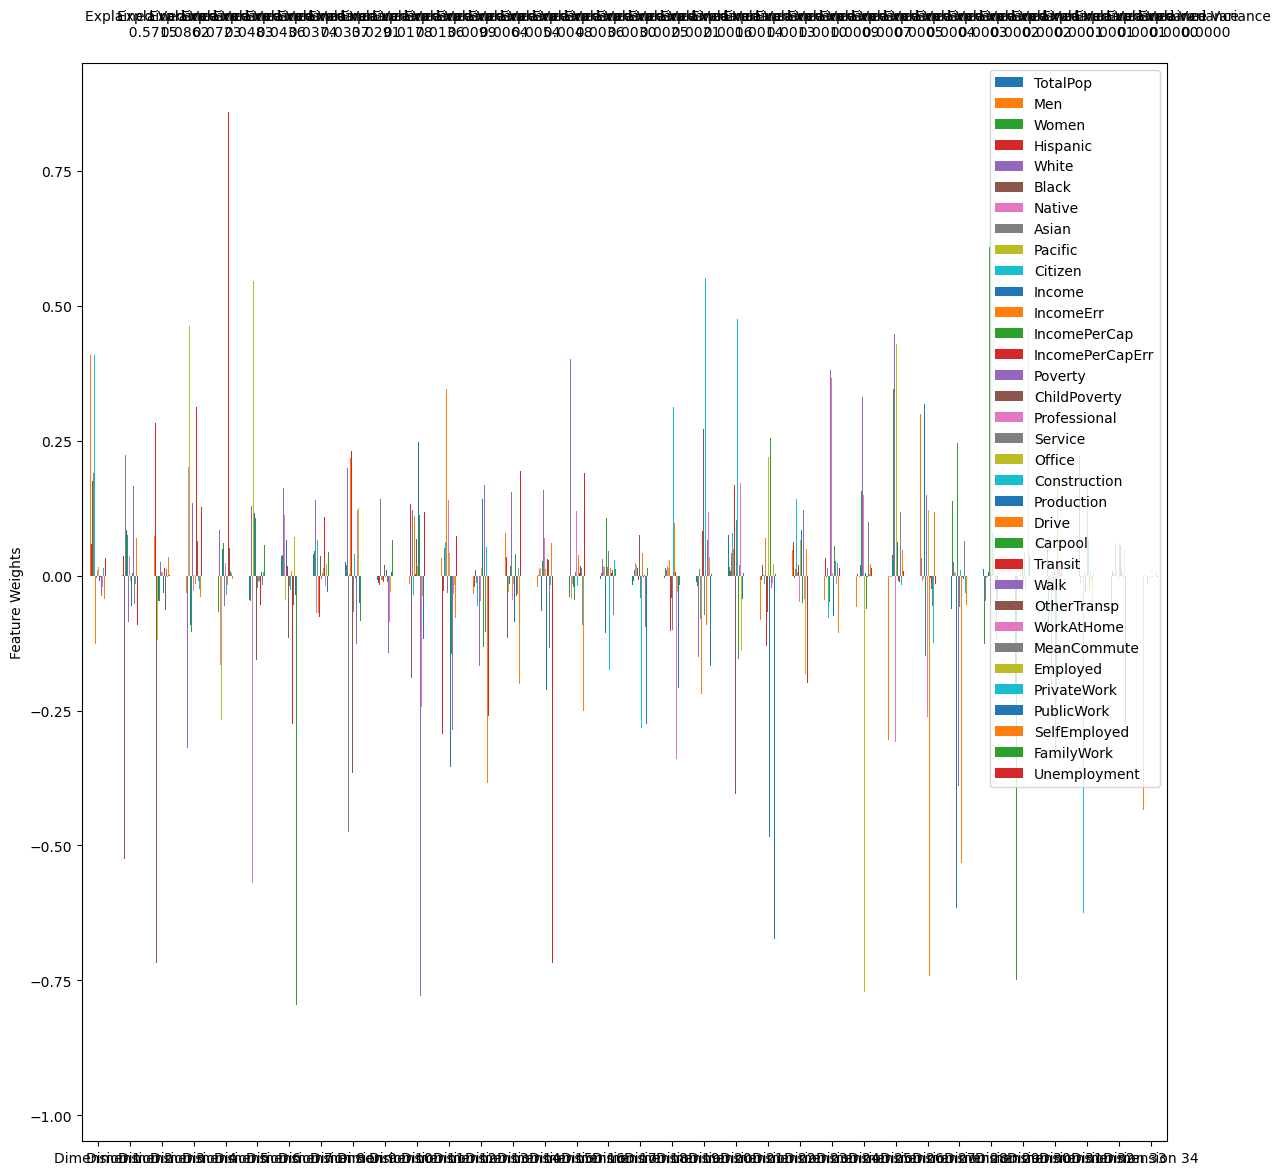

In [47]:
pca_results(good_data, pca)

[0.57154011 0.65772202 0.73000469 0.77834037 0.82193501 0.85937648
 0.89305384 0.92217639 0.93995615 0.95353546 0.96345727 0.96980914
 0.97523639 0.98006717 0.98367819 0.9867257  0.98919188 0.99128192
 0.99290044 0.99434305 0.9956231  0.99665555 0.99750718 0.99820446
 0.99867094 0.99904148 0.99932826 0.99954579 0.99972214 0.9998289
 0.99991161 0.9999648  0.99999935 1.        ]


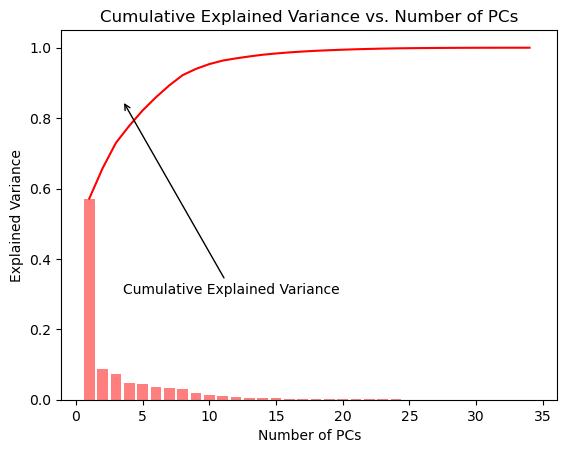

In [48]:
num_components = np.arange(1, 35)
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance_explained)
plt.plot(num_components, cumulative_variance_explained, '-r');
plt.annotate('Cumulative Explained Variance', xy=(3.5, 0.85), arrowprops=dict(arrowstyle='->'),xytext=(3.5, .3))
plt.bar(num_components, pca.explained_variance_ratio_, align='center', alpha=0.5, color='red')
plt.xlabel('Number of PCs'); plt.ylabel('Explained Variance'); plt.title('Cumulative Explained Variance vs. Number of PCs');

In [49]:
# samples1

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0    -2.347586     0.076401     0.490462    -0.446783     0.055979   
1     0.491355     0.107589     0.136390    -0.241926    -0.071441   
2     0.385947    -0.165983    -0.464898     0.046406    -0.167516   
3    -1.052730     0.103614    -0.061930    -0.182096    -0.256132   
4    -0.990252     0.202933    -0.028433    -0.280591    -0.243744   
5    -0.257818    -0.422755    -0.302062    -0.138770    -0.411114   
6     1.385811    -0.129461     0.106408    -0.254577     0.047418   
7    -0.093545     0.030990     0.090722    -0.185440     0.075821   
8    -0.214714     0.653852    -0.400975     0.782959    -0.011913   
9    -0.077883    -0.373914     1.063789     0.375208    -0.118553   

   Dimension 6  Dimension 7  Dimension 8  Dimension 9  Dimension 10  ...  \
0     0.294086    -0.077194     0.148890     0.030784     -0.362435  ...   
1    -0.116296     0.195880     0.020090     0.016016     -0.020229  ...   
2    -0.324755    -0.071172    -0.086180    -0.125290      0.044937  ...   
3     0.027308     0.146776    -0.182662     0.033758     -0.045201  ...   
4     0.037143     0.155119    -0.144808     0.053624     -0.001628  ...   
5    -0.051408    -0.025463    -0.098227    -0.139527      0.005513  ...   
6    -0.157558     0.095187     0.150720    -0.016327      0.080245  ...   
7    -0.016206     0.008556     0.000233    -0.066189      0.021945  ...   
8    -0.283917     0.346698     0.072169    -0.339589     -0.367413  ...   
9    -0.242967    -0.545852    -0.008974    -0.082358     -0.004944  ...   

   Dimension 25  Dimension 26  Dimension 27  Dimension 28  Dimension 29  \
0     -0.041280      0.028224      0.072624     -0.013188      0.008099   
1     -0.005345     -0.007235      0.009919     -0.002543     -0.017521   
2      0.014386      0.008898     -0.010664      0.007843      0.000675   
3     -0.015362     -0.013592     -0.009031      0.004958      0.002486   
4     -0.014785      0.021006      0.003085     -0.015154      0.012446   
5      0.003573      0.001162     -0.006155     -0.008014     -0.014416   
6      0.008447     -0.005174      0.004516      0.002791      0.001006   
7     -0.007081     -0.010428     -0.001653      0.005252      0.001916   
8     -0.034602     -0.012091      0.108487      0.016323     -0.000203   
9     -0.035095     -0.002026     -0.018288      0.017703      0.016453   

   Dimension 30  Dimension 31  Dimension 32  Dimension 33  Dimension 34  
0     -0.004475     -0.014890      0.007791      0.021393     -0.004297  
1     -0.000912     -0.007308      0.001884     -0.001672      0.000602  
2     -0.005780      0.005498     -0.002213     -0.002269      0.000007  
3     -0.003898      0.002690     -0.006830      0.002602      0.000148  
4      0.006039      0.006153      0.004023      0.007006      0.000188  
5      0.012776     -0.011346     -0.002709     -0.002205     -0.000126  
6      0.003389     -0.001558     -0.001821      0.006707     -0.000669  
7     -0.001135      0.001627     -0.009496      0.002354      0.000393  
8     -0.020494     -0.035125      0.004637      0.002899      0.000445  
9      0.001715     -0.001799      0.004656     -0.006809      0.000233  

[10 rows x 34 columns]

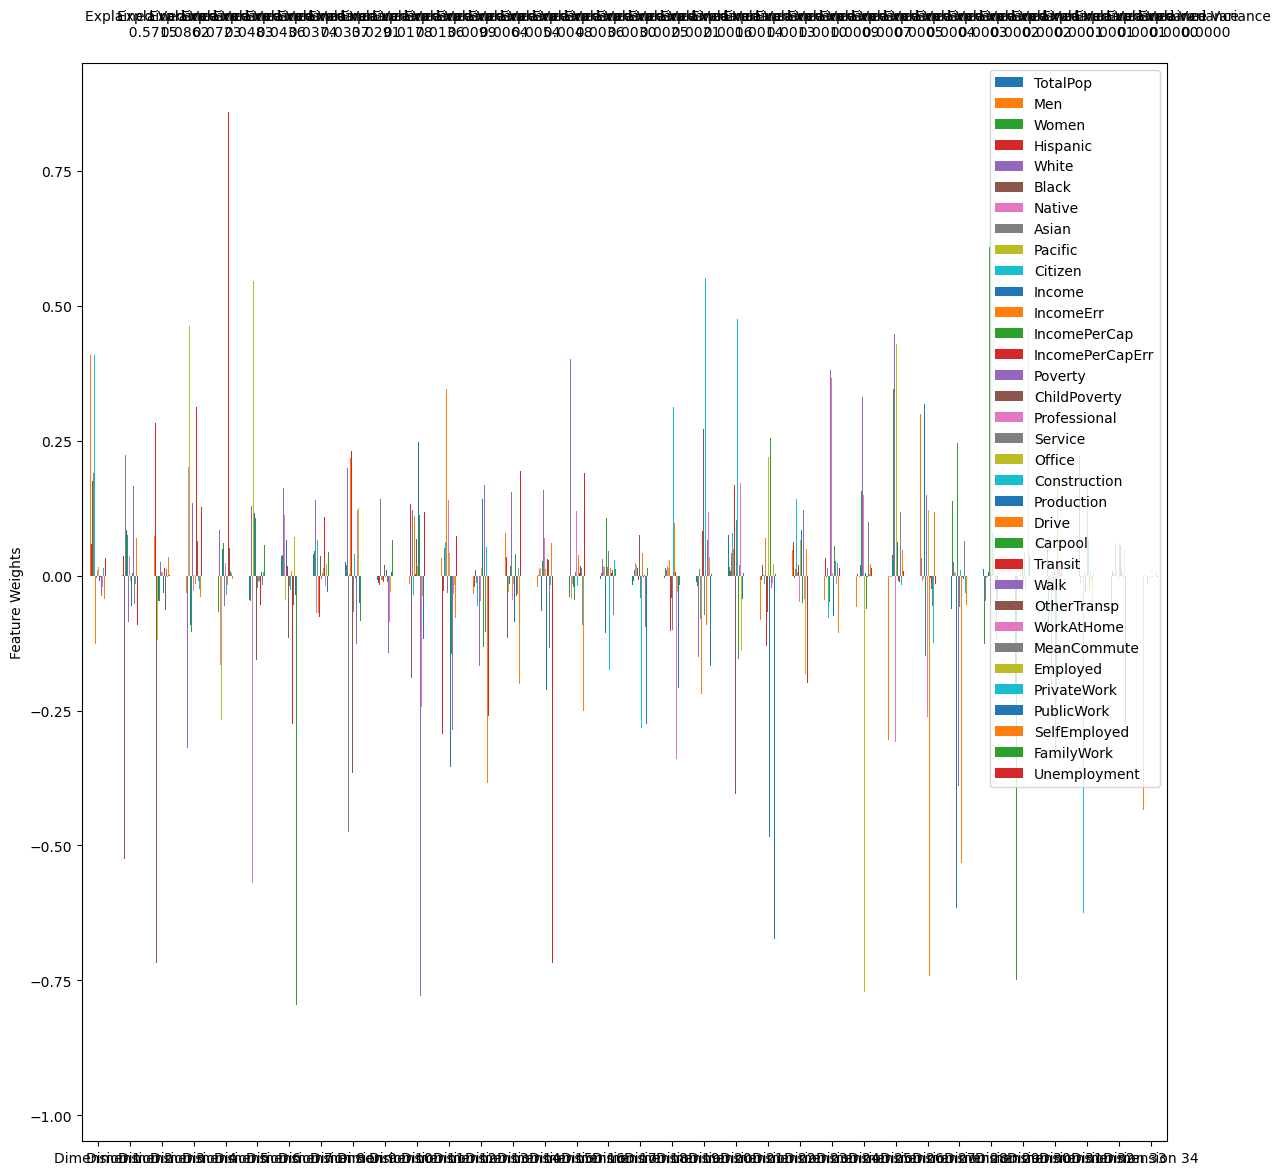

In [67]:

pca_samples = pd.DataFrame(pca_samples, columns = pca_results(good_data, pca).index.values)
pca_samples


Explained Variance  TotalPop     Men   Women  Hispanic   White  \
Dimension 1              0.5715    0.4165  0.4078  0.4144    0.0579 -0.0095   
Dimension 2              0.0862   -0.0043  0.0007 -0.0073    0.0366  0.1005   
Dimension 3              0.0723    0.0798  0.0740  0.0857    0.2821 -0.2641   

              Black  Native   Asian  Pacific  ...    Walk  OtherTransp  \
Dimension 1  0.1747  0.0167  0.1893   0.0408  ... -0.0369       0.0322   
Dimension 2 -0.5254  0.6083  0.2239   0.2607  ...  0.1662       0.0744   
Dimension 3 -0.7177 -0.4425 -0.2689  -0.1186  ...  0.0456      -0.0635   

             WorkAtHome  MeanCommute  Employed  PrivateWork  PublicWork  \
Dimension 1     -0.0214       0.0154    0.4174       0.0140     -0.0209   
Dimension 2      0.1539      -0.0518    0.0468      -0.0150     -0.0007   
Dimension 3      0.0021       0.0123    0.0654      -0.0019     -0.0152   

             SelfEmployed  FamilyWork  Unemployment  
Dimension 1       -0.0439      0.0104        0.0325  
Dimension 2        0.0692      0.3107       -0.0921  
Dimension 3        0.0342     -0.0029        0.0016  

[3 rows x 35 columns]

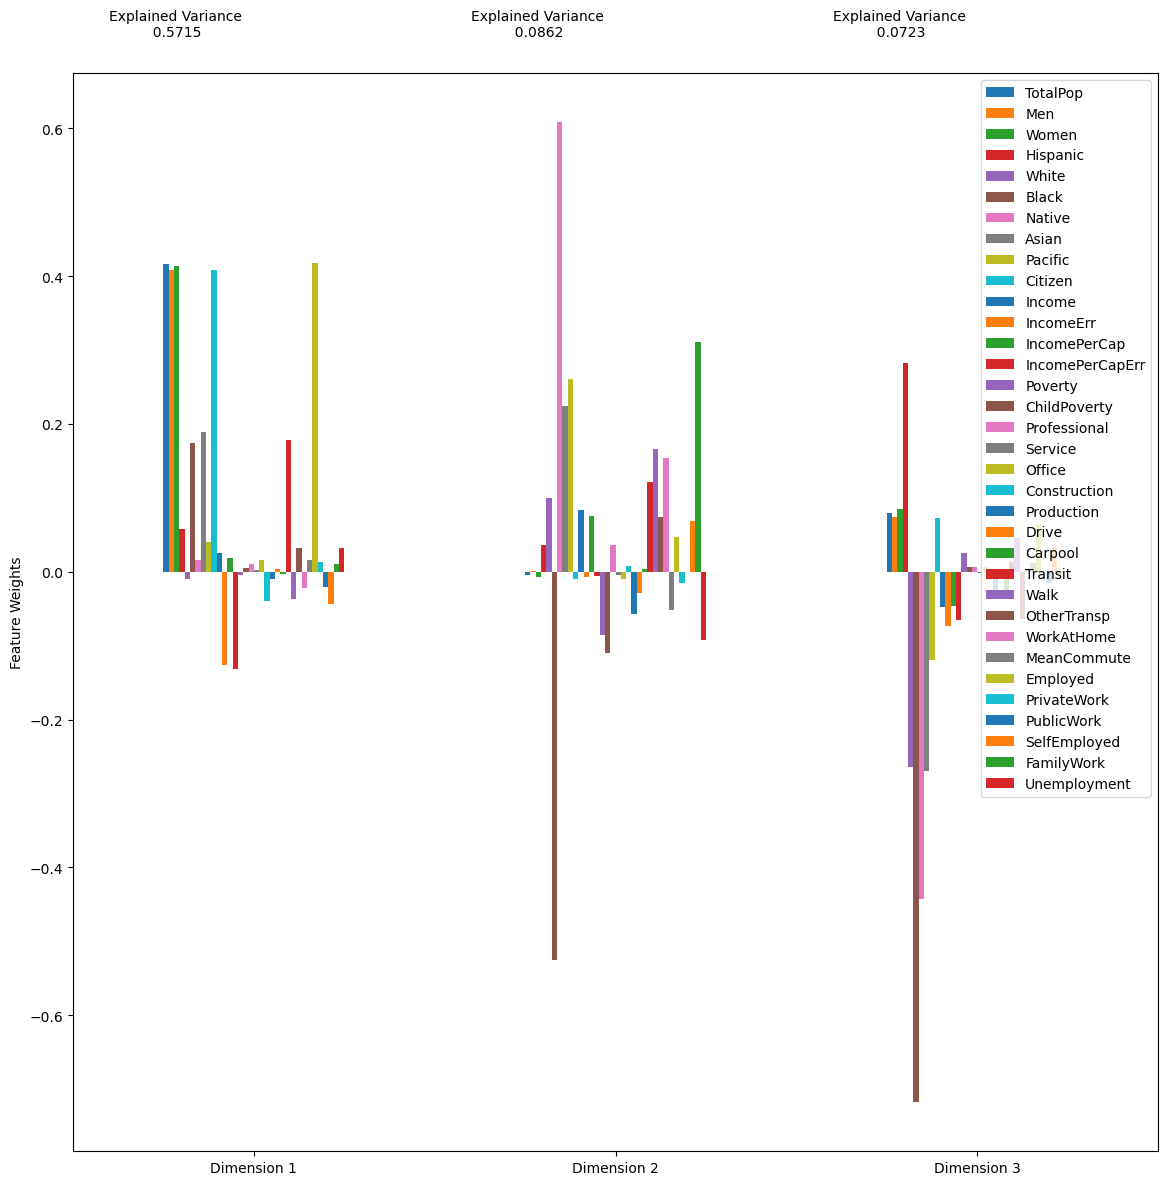

In [51]:

pca = PCA(n_components=3).fit(good_data)
reduced_data = pca.transform(good_data)
pca_samples = pca.transform(log_samples)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3'])
pca_results(good_data, pca)

The first and second principal components explain a total of 65.77% of the variance in the data. The first three principal components explain a total of 75.00% of the total variance in the data. This suggests that only the first three principal components need to be kept to represent all of the data without a significant loss of information.

The weights of the features in the principal components is another method of finding correlations between the features. For example, in the first principal component, the White, IncomeErr, IncomeperCapitalErr, Poverty, Construction, Production, Carpool, Walk, WorkAtHome, PublicWork and SelfEMployed features are all weighted negatively, with IncomeperCapitalErr carrying the most negative weight. This means that as values are increased along the first prinicipal dimension, White, IncomeErr, IncomeperCapitalErr, Poverty, Construction, Production, Carpool, Walk, WorkAtHome, PublicWork and SelfEMployed features all decrease with IncomeperCapitalErr  decreasing the greatest amount. On the other hand, other features increase moving positively along the first principal component. Therefore, we can conclude that the first principal component demonstrates that customers fall into two groups along this component. The "strongest" grouping, or the one that should be the main focus of the distributor, is that shown by the first principal component because that is the dimension that explains the greatest percentage of the variance in the dataset.

In [53]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2', 'Dimension 3']))

Dimension 1  Dimension 2  Dimension 3
0      -2.3476       0.0764       0.4905
1       0.4914       0.1076       0.1364
2       0.3859      -0.1660      -0.4649
3      -1.0527       0.1036      -0.0619
4      -0.9903       0.2029      -0.0284
5      -0.2578      -0.4228      -0.3021
6       1.3858      -0.1295       0.1064
7      -0.0935       0.0310       0.0907
8      -0.2147       0.6539      -0.4010
9      -0.0779      -0.3739       1.0638

In [54]:
display(pd.DataFrame(np.round(reduced_data, 4), columns = ['Dimension 1', 'Dimension 2', 'Dimension 3']))

Dimension 1  Dimension 2  Dimension 3
0          0.3700      -0.3274      -0.2765
1          0.9961      -0.0199      -0.0552
2          0.0361      -0.3689      -0.3319
3         -0.1092      -0.2430      -0.3217
4          0.3024      -0.0134       0.1368
...           ...          ...          ...
3215       0.1871      -0.5987       1.0131
3216      -0.8241      -0.1440       1.2184
3217      -0.3501      -0.3115       1.5416
3218      -0.1678      -0.3439       1.2546
3219      -0.0717      -0.3509       1.3805

[3220 rows x 3 columns]

# KMeans Clustering

C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 2; Silhouette Score = 0.3971


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 3; Silhouette Score = 0.3500


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 4; Silhouette Score = 0.2986


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 5; Silhouette Score = 0.3214


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 6; Silhouette Score = 0.3269


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 7; Silhouette Score = 0.3118


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 8; Silhouette Score = 0.2997


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 9; Silhouette Score = 0.2896


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Clusters: 10; Silhouette Score = 0.2691


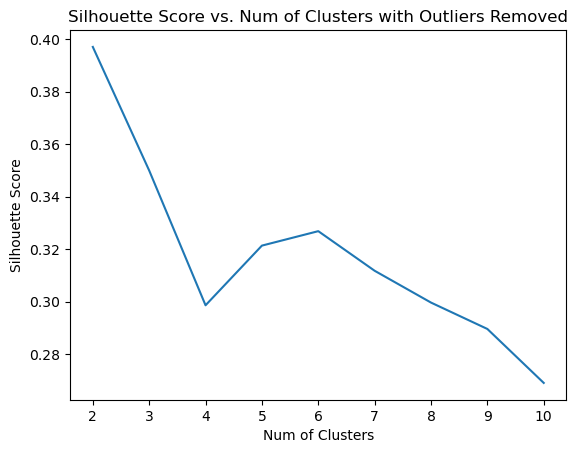

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
for i in range(2, 11):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    n_clusters = i
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_
    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    scores.append(score)
    print('Clusters: {}; Silhouette Score = {:.4f}'.format(n_clusters, score))
    
plt.plot(np.arange(2,11), scores);
plt.xlabel('Num of Clusters'); plt.ylabel('Silhouette Score'); plt.title('Silhouette Score vs. Num of Clusters with Outliers Removed');

In [58]:
# Create clustering model with optimal number of components as measured by silhouette score 
clusterer = KMeans(n_clusters=2, random_state=42, n_init='auto')

# Fit to the processed data and make predictions
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
sample_preds = clusterer.predict(pca_samples)
centers = clusterer.cluster_centers_


C:\Users\OMO_MUSHIN\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


C:\Users\OMO_MUSHIN\AppData\Local\Temp\ipykernel_9092\1477139749.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow')


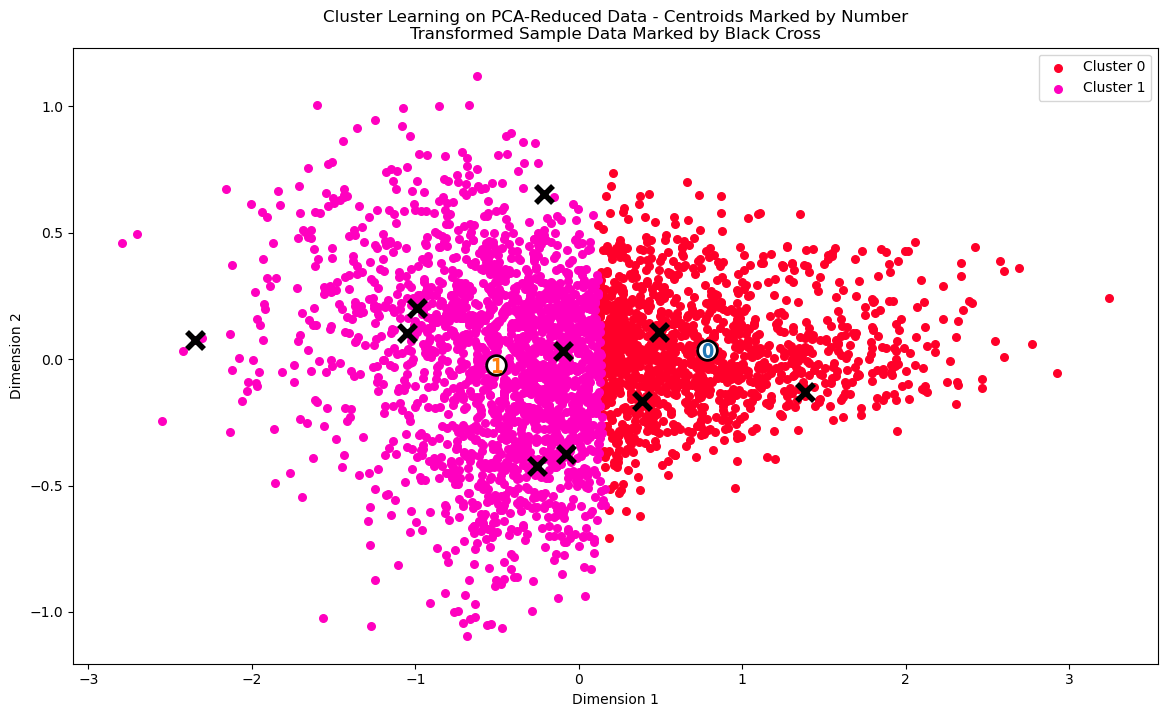

In [59]:
cluster_results(reduced_data, preds, centers, pca_samples)

# Data Recovery


In [60]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp((log_centers))**4

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = samples1.keys())
true_centers.index = segments
print("Centers of clusters:")
display(true_centers)

Centers of clusters:


TotalPop      Men    Women  Hispanic  White  Black  Native  Asian  \
Segment 0  145639.0  74950.0  76442.0      46.0  217.0   38.0     9.0   19.0   
Segment 1   16969.0   9122.0   9006.0      34.0  223.0   18.0     7.0    7.0   

           Pacific   Citizen  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  \
Segment 0      2.0  108367.0  ...  23.0         20.0        32.0        107.0   
Segment 1      1.0   13137.0  ...  27.0         16.0        35.0        100.0   

           Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
Segment 0   66964.0        249.0        78.0          43.0         6.0   
Segment 1    7671.0        232.0        87.0          53.0         6.0   

           Unemployment  
Segment 0          53.0  
Segment 1          46.0  

[2 rows x 34 columns]

Segment 0: The first segment most likely represents a Big City. 

Segment 1: The second segment could be a small city like a county, residential area. 

Percentile scores of cluster centers: 


TotalPop    Men  Women  Hispanic  White  Black  Native  Asian  \
Segment 0     86.18  86.89  86.89     94.13  100.0  93.62   96.15  99.57   
Segment 1     36.24  38.63  38.01     91.83  100.0  83.29   95.17  97.67   

           Pacific  Citizen  ...   Walk  OtherTransp  WorkAtHome  MeanCommute  \
Segment 0    99.66    86.55  ...  99.35        99.81       99.94        100.0   
Segment 1    99.13    37.02  ...  99.53        99.75       99.97        100.0   

           Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
Segment 0     86.52        100.0       100.0         100.0       99.91   
Segment 1     39.91        100.0       100.0         100.0       99.91   

           Unemployment  
Segment 0         100.0  
Segment 1         100.0  

[2 rows x 34 columns]

In [62]:
sample_preds

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [63]:
for i, pred in enumerate(preds):
    print ("Sample point", i, "predicted to be in Segment", pred)

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1
Sample point 3 predicted to be in Cluster 1
Sample point 4 predicted to be in Cluster 0
Sample point 5 predicted to be in Cluster 1
Sample point 6 predicted to be in Cluster 1
Sample point 7 predicted to be in Cluster 0
Sample point 8 predicted to be in Cluster 1
Sample point 9 predicted to be in Cluster 1
Sample point 10 predicted to be in Cluster 0
Sample point 11 predicted to be in Cluster 1
Sample point 12 predicted to be in Cluster 1
Sample point 13 predicted to be in Cluster 1
Sample point 14 predicted to be in Cluster 1
Sample point 15 predicted to be in Cluster 0
Sample point 16 predicted to be in Cluster 0
Sample point 17 predicted to be in Cluster 1
Sample point 18 predicted to be in Cluster 1
Sample point 19 predicted to be in Cluster 0
Sample point 20 predicted to be in Cluster 1
Sample point 21 predicted to be in Cluster 0
Sample point 22 pred

In [65]:
log_data.shape

(3220, 34)